# **TELCO CUSTOMER CHURN**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce # untuk ordinal dan binary encoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score, fbeta_score, make_scorer

from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


## **BUSINESS UNDERSTANDING**


**Context**  
Saat ini industri telekomunikasi seluler telah berkembang pesat, sehingga persaingan antar provider (perusahaan operator telekomunikasi seluler) menjadi semakin ketat. Salah satu tantangan yang kini dihadapi provider adalah usaha
menurunkan jumlah pelanggan yang berhenti menggunakan layanan perusahaan dan beralih langganan ke perusahaan kompetitor.

Suatu provider ingin mengetahui pelanggan yang bagaimana yang akan pindah (churn) dari provider tersebut sehingga jumlah pelanggan yang beralih (churn) dapat dikurangi. Seorang Data Scientist diminta untuk membuat model prediksi yang tepat untuk menentukan pelanggan akan berhenti berlangganan (churn) atau tidak dengan menggunakan machine learning. 

Target :

0 : Tidak berhenti berlangganan

1 : Berhenti berlangganan (churn)

**Problem Statement :**

Tingginya persentase customer churn menjadi salah satu indikator tingkat kegagalan suatu perusahaan telekomunikasi, maka perlu dilakukan upaya-upaya untuk mengurangi persentase customer churn tersebut. Perusahaan umumnya lebih memilih untuk mempertahankan pelanggan, karena dibutuhkan biaya yang lebih sedikit untuk mempertahankan pelanggan {customer retention cost) daripada menambah pelanggan yang baru (customer acquisition cost). Berdasarkan informasi dari [internet](https://www.outboundengine.com/blog/customer-retention-marketing-vs-customer-acquisition-marketing/), memperoleh pelanggan baru dapat menghabiskan biaya lima kali lebih banyak daripada mempertahankan pelanggan yang sudah ada. Adapun rata-rata biaya customer acquisition cost untuk industri telekomunikasi adalah sekitar $315 per new customer ([sumber](https://www.revechat.com/blog/customer-acquisition-cost/)).

Perusahaan telekomunikasi dapat memberikan insentif retensi seperti memberikan potongan harga, memberikan paket layanan yang menarik, memberikan
prioritas pelayanan dan lain-lain dalam upaya untuk mempertahankan pelanggan. Namun, kebijakan pemberian insentif retensi belum sepenuhnya dilakukan secara efektif. Karena jika insentif retensi tersebut diberikan secara merata kepada seluruh pelanggan, maka pengeluaran biaya tersebut menjadi tidak efektif dan mengurangi potensi keuntungan apabila pelanggan tersebut memang loyal dan tidak ingin berhenti berlangganan.


**Goals :**

Maka berdasarkan permasalahan-permasalahan di atas, perusahaan ingin memiliki kemampuan untuk memprediksi kemungkinan seorang pelanggan akan berhenti berlangganan atau tidak, sehingga dapat memfokuskan upaya-upaya retensi pada pelanggan yang terindikasi untuk churn.

Dan juga, perusahaan ingin mengetahui faktor-faktor apa saja yang cenderung mempengaruhi pelanggan bertahan, sehingga mereka dapat membuat program-program yang lebih tepat sasaran dalam mengurangi jumlah pelanggan yang churn.

**Analytic Approach :**

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan pelanggan yang akan berhenti berlangganan (churn) atau tidak.

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang pelanggan akan berhenti berlangganan (churn) atau tidak.

**Metric Evaluation**

Karena fokus utama kita adalah pelanggan yang akan berhenti berlangganan, maka target yang kita tetapkan adalah sebagai berikut:

Target :
- 0 : Tidak berhenti berlangganan
- 1 : Berhenti berlangganan (churn)

Type 1 error : False Positive (pelanggan yang aktualnya tidak churn tetapi diprediksi churn)
Konsekuensi: tidak efektifnya pemberian insentif retensi

Type 2 error : False Negative (pelanggan yang aktualnya churn tetapi diprediksi tidak akan churn)
Konsekuensi: kehilangan pelanggan

Untuk memberikan gambaran konsekuensi secara kuantitatif, maka kita akan coba hitung dampak biaya berdasarkan asumsi berikut :
- Customer Lifetime Period untuk pelanggan yang churn sekitar 17.7 bulan 
- Customer Acquisition Cost (CAC) = $315 per customer ([sumber](https://www.revechat.com/blog/customer-acquisition-cost/)) / 17.7 bulan = $17.79 per bulan per customer
- Customer Retention Cost (CRC)= 1/5 ([sumber](https://www.outboundengine.com/blog/customer-retention-marketing-vs-customer-acquisition-marketing/)) * CAC = 1/5 * $17.79 = $3.56 per bulan per customer
- Average Customer MonthlyCharge = $64.88 per bulan per customer

Berdasarkan asumsi di atas maka kita dapat coba kuantifikasi konsekuensinya sebagai berikut :
- tidak efektifnya pemberian insentif retensi --> maka kita menyia-nyiakan biaya CRC sebesar $3.56 per bulan per pelanggan
- kehilangan pelanggan --> maka kita kehilangan pendapatan dan juga perlu mengeluarkan kembali biaya CAC sehingga secara total kita kehilangan $17.79 + $64.88 = $82.67 per bulan per pelanggan

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi customer churn dari perusahaan tersebut, khususnya jumlah False Negative (pelanggan yang aktualnya churn tetapi diprediksi tidak akan churn), tetapi juga dapat meminimalisir pemberian insentif yang tidak tepat. Jadi nanti metric utama yang akan kita gunakan adalah f2_score, karena recall kita anggap dua kali lebih penting daripada precision.

In [2]:
# F2 score (Karena cost dari FN (diprediksi tidak churn, padahal aslinya churn) lebih tinggi dari pada FP (diprediksi churn, padahal aslinya tidak churn))
f2_score = make_scorer(fbeta_score, beta=2)

## **DATA UNDERSTANDING**

### *ATTRIBUTE INFORMATION*

Pertama-tama kita akan mencoba untuk memahami data yang tersedia. Dataset dapat diakses [disini](https://drive.google.com/file/d/1oB5uKtJr7dWcWr9Ld5ZFAuVkpV005ceH/view)

In [3]:
df = pd.read_csv('data_telco_customer_churn.csv')
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


In [4]:
# menampilkan informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


In [5]:
# menghitung jumlah churn
df['Churn'].value_counts()

No     3614
Yes    1316
Name: Churn, dtype: int64

In [6]:
# menghitung pesentase churn
df['Churn'].value_counts()/len(df)

No     0.733063
Yes    0.266937
Name: Churn, dtype: float64

In [7]:
# mengecek jumlah missing values
df.isna().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

Dataset ini berisi informasi tentang :

- Informasi demografi pelanggan yaitu `Dependents`.
- Service yang digunakan oleh pelanggan : `Online Security`, `Online Backup`, `Internet Service`, `Device Protection`, `Tech Support`
- Informasi akun pelanggan : `tenure`, `Contract`, `PaperlessBilling`, dan `MonthlyCharges`
- Pelanggan yang berhenti berlangganan – kolomnya disebut `Churn`

Deskripsi terkait kolom-kolom pada dataset Telco Customer Churn tersebut, dapat dilihat pada tabel berikut :  

| Attribute | Data Type | Description |
| --- | --- | --- |
| Dependents | Text | Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc. |
| tenure | Integer | Indicates the total amount of months that the customer has been with the company.  |
| OnlineSecurity | Text | Indicates if the customer subscribes to an additional online security service provided by the company. |
| OnlineBackup | Text | Indicates if the customer subscribes to an additional online backup service provided by the company. |
| InternetService | Text | Indicates if the customer subscribes to Internet service with the company. |
| DeviceProtection | Text | Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company. |
| TechSupport | Text | Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times. |
| Contract | Text | Indicates the customer’s current contract type. |
| PaperlessBilling | Text | Indicates if the customer has chosen paperless billing. |
| MonthlyCharges | Float | Indicates the customer’s current total monthly charge for all their services from the company. |
| Churn | Text | Yes = the customer left the company this quarter. No = the customer remained with the company. |

- Sumber data : https://drive.google.com/file/d/1oB5uKtJr7dWcWr9Ld5ZFAuVkpV005ceH/view
- Pembuat data : IBM
- Periode pembuatan data : Juli 2019

Note : 
- Setiap baris data merepresentasikan informasi seorang pelanggan
- Sebagian besar feature bersifat kategorikal :
    - Kategorikal : `Dependents, Online Security, Online Backup, Internet Service, Device Protection, Tech Support, Contract, PaperlessBilling`
    - Numerikal : `tenure, MonthlyCharges`
- Target adalah kolom `Churn` (No = 3614 data, Yes = 1316 data)
- Dataset tidak seimbang (mild imbalance) karena proporsi kelas minoritas sebesar 26.69% berada dalam rentang 20-40% dari dataset ([sumber](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data))
- Tidak terdapat missing values pada dataset


In [8]:
# menampilkan jumlah unik dan unique values untuk setiap kolom
pd.set_option('display.max_colwidth', None)
# data uni di tiap kolom
listItem = []
for col in df.columns :
    listItem.append( [col, df[col].nunique(), df.sort_values(col)[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Values'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Values
0,Dependents,2,"[No, Yes]"
1,tenure,73,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]"
2,OnlineSecurity,3,"[No, No internet service, Yes]"
3,OnlineBackup,3,"[No, No internet service, Yes]"
4,InternetService,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,3,"[No, No internet service, Yes]"
6,TechSupport,3,"[No, No internet service, Yes]"
7,Contract,3,"[Month-to-month, One year, Two year]"
8,PaperlessBilling,2,"[No, Yes]"
9,MonthlyCharges,1422,"[18.8, 18.85, 18.9, 18.95, 19.0, 19.05, 19.1, 19.15, 19.2, 19.25, 19.3, 19.35, 19.4, 19.45, 19.5, 19.55, 19.6, 19.65, 19.7, 19.75, 19.8, 19.85, 19.9, 19.95, 20.0, 20.05, 20.1, 20.15, 20.2, 20.25, 20.3, 20.35, 20.4, 20.45, 20.5, 20.55, 20.6, 20.65, 20.7, 20.75, 20.8, 20.85, 20.9, 20.95, 21.0, 21.05, 21.1, 21.15, 21.2, 21.3, 21.45, 22.95, 23.3, 23.45, 23.55, 23.6, 23.65, 23.75, 23.8, 23.85, 23.9, 23.95, 24.0, 24.05, 24.1, 24.15, 24.2, 24.25, 24.3, 24.35, 24.4, 24.45, 24.5, 24.55, 24.6, 24.65, 24.7, 24.75, 24.8, 24.85, 24.9, 24.95, 25.0, 25.05, 25.1, 25.15, 25.2, 25.25, 25.3, 25.35, 25.4, 25.45, 25.5, 25.55, 25.6, 25.7, 25.75, 25.8, 25.85, 25.9, ...]"


In [9]:
df.describe(include='all')

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
count,4930,4930.000000,4930,4930,4930,4930,4930,4930,4930,4930.000000,4930
unique,2,NaN,3,3,3,3,3,3,2,NaN,2
top,No,NaN,No,No,Fiber optic,No,No,Month-to-month,Yes,NaN,No
freq,3446,NaN,2445,2172,2172,2186,2467,2721,2957,NaN,3614
mean,NaN,32.401217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.883032,NaN
std,NaN,24.501193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.923960,NaN
min,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.800000,NaN
25%,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.050000,NaN
50%,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


Dari informasi di atas dapat dilihat bahwa :
* **tenure** berupa data diskrit dengan nilai bervariasi antara 0 sampai dengan 72 bulan dengan median DI ANGKA 29 bulan
* **MonthlyCharges** berupa data kontinu dengan nilai minimum sebesar 18.8 dan nilai maksimal di angka 118.65
* **Dependent, Paperless Billing, dan Churn** memiliki nilai 'Yes' atau 'No'
* **InternetService** berisi pilihan berupa 'DSL', 'Fiber Optic' dan 'No'
* **OnlineSecurity, OnlineBackup, DeviceProtection, dan TechSupport** berisi pilihan 'Yes', 'No' atau 'No internet service'.
* Terdapat 3 pilihan **Contract** yaitu Month-to-month, One year, dan Two Year


### *EXPLORATORY DATA ANALYSIS*

#### Categorical Features

In [10]:
# mengambil nama kolom kategorikal
cat_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
cat_features

['Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'InternetService',
 'DeviceProtection',
 'TechSupport',
 'Contract',
 'PaperlessBilling',
 'Churn']

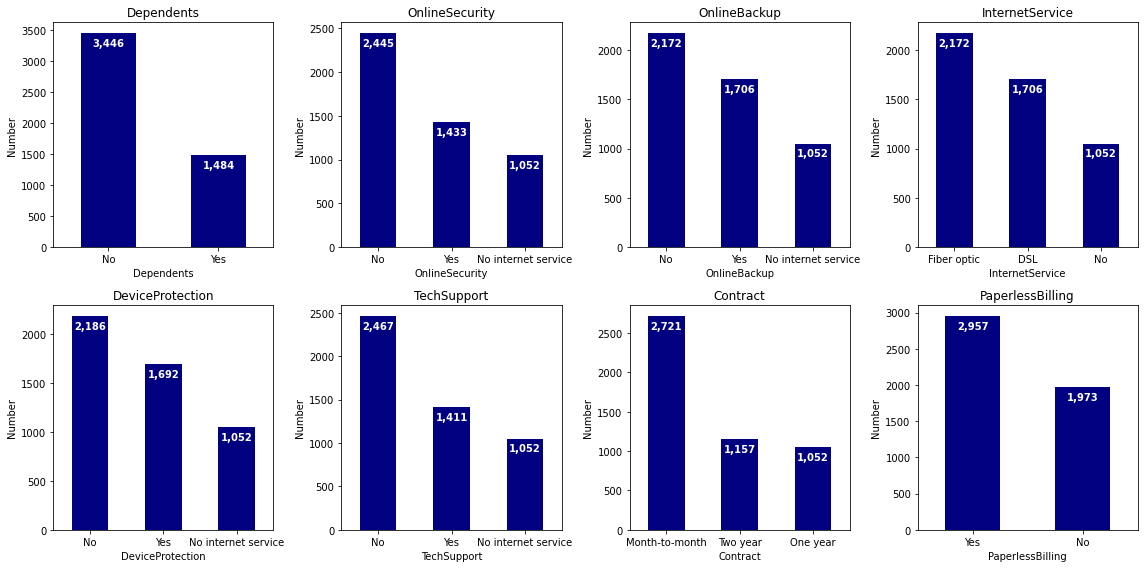

In [11]:
# membuat barplot value_counts untuk setiap kolom kategorikal
plt.figure(figsize=(16, 8), facecolor='white')
plotnumber = 1

for feature in cat_features[:-1]:
    # subplot (letak grafik)
    ax = plt.subplot(2, 4, plotnumber)
    
    # Harga rumah berdasarkan feature 
    ax = df[feature].value_counts().plot(kind = 'bar', rot = 0, color=['navy'])
    
    plt.ylabel('Number')
    plt.xlabel(feature)
    plt.title(feature, fontsize=12)
    container = ax.containers[0]
    ax.bar_label(container , labels=[f'{x:,.0f}' for x in container.datavalues], label_type='edge', padding = -15, color="white", fontweight='bold')
    plt.tight_layout();
    
    plotnumber += 1

Dari data di atas kita dapat melihat bahwa :
- Mayoritas pelanggan tidak memiliki `Dependents` (anak, orangtua, kakek/nenek, dll).
- Layanan internet yang paling banyak digunakan adalah Fiber optic diikuti oleh DSL, sedangkan sisanya sebanyak 1052 pelanggan tidak menggunakan layanan internet.
- Kebanyakan pelanggan tidak menggunakan layanan `OnlineSecurity`, `OnlineBackup`, `Device Protection`, dan `Tech Support`.
- Pelanggan paling banyak menggunakan kontrak jangka pendek (Month-to-month) dibandingkan kontrak jangka panjang (One year dan Two year).
- Mayoritas pelanggan menggunakan `Paperlessbilling`.

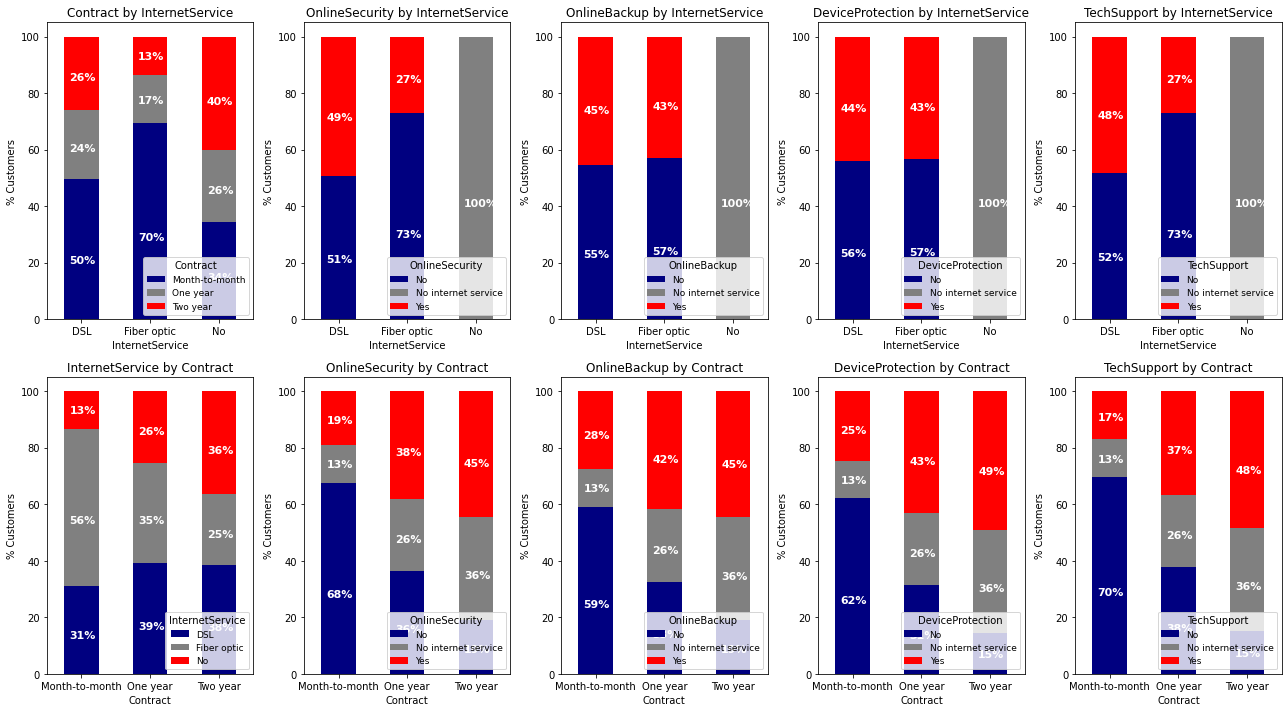

In [12]:
# membuat stacked bar chart untuk melihat proporsi setiap layanan berdasarkan Internet Service dan Contract
plt.figure(figsize=(18, 10), facecolor='white')
plotnumber = 1

for base in ['InternetService', 'Contract'] :
    if base == 'InternetService':
        list_features = ['Contract', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
    else :
        list_features = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
    
    for feature in list_features:

        column1 = base
        column2 = feature

        # membuat table berdasarkan 2 kolom kategorikal
        groupby_table = df.groupby([column1,column2]).size().unstack()

        # fungsi untuk pelabelan dimana jika nilainya 0 tidak akan ditampilkan
        def show() :
            if height > 0 :
                return '{:.0f}%'.format(height)
            else :
                return '' 
        
        # subplot (letak grafik)
        ax = plt.subplot(2, 5, plotnumber)
        
        # Harga rumah berdasarkan feature 
        (groupby_table.T*100.0 / groupby_table.T.sum()).T.plot(kind='bar',
                                                                width = 0.5,
                                                                stacked = True,
                                                                rot = 0, 
                                                                ax = ax,
                                                                color = ['navy', 'grey', 'red'])

        ax.legend(loc = 'lower right', prop={'size':9},title = column2)
        ax.set_ylabel('% Customers')
        ax.set_title(f'{column2} by {column1}',size = 12)

        # menambahkan label data pada stacked bar chart
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate(show(), (p.get_x()+0.15*width, p.get_y()+.4*height),
                        color = 'white',
                        weight = 'bold',
                        size = 11)
        
        plt.tight_layout();
        
        plotnumber += 1

Dari grafik di atas kita juga dapat melihat bahwa :
- Mayoritas pengguna 'Fiber optic' lebih banyak memilih `Contract` 'Month-to-month'.
- Mayoritas pengguna 'Fiber optic' juga tidak menggunakan layanan `OnlineSecurity` dan `TechSupport`
- Pelanggan dengan `Contract` 'Month-to-month' umumnya tidak menggunakan layanan `Online Security`, `Online Backup`, `DeviceProtection`, dan `TechSupport`
- Sedangkan pelanggan dengan `Contract` 'Two year' lebih banyak menggunakan layanan `Online Security`, `Online Backup`, `DeviceProtection`, dan `TechSupport`
- Sehingga kita dapat asumsikan  bahwa pelanggan dengan kontrak yang lebih panjang cenderung memiliki engagement untuk penggunaan layanan yang lebih tinggi.

#### Numerical Features

In [13]:
# Numerical Features
num_feature = [feature for feature in df.describe().columns]
num_feature

['tenure', 'MonthlyCharges']

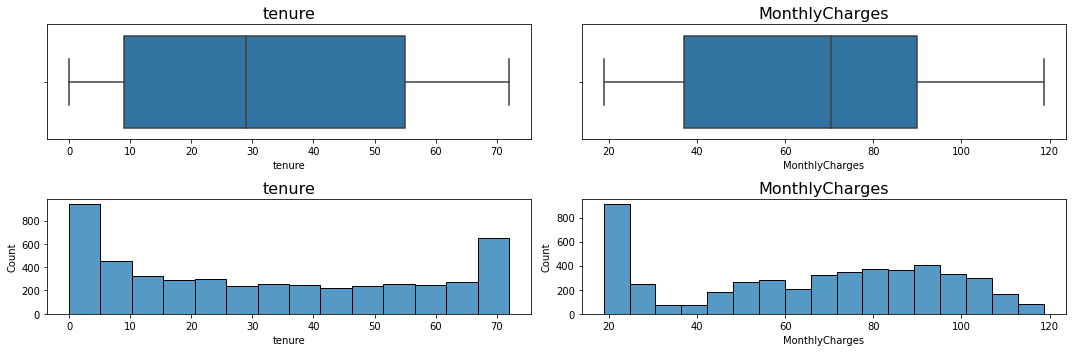

In [14]:
# boxplot
plt.figure(figsize=(15, 5), facecolor='white')
plotnumber = 1
    
for feature in num_feature:
    ax = plt.subplot(2,2, plotnumber)
    sns.boxplot(x=feature, data=df);
    plt.title(feature, fontsize=16)
    plt.tight_layout()
    plotnumber += 1

for feature in num_feature:
    ax = plt.subplot(2,2, plotnumber)
    sns.histplot(x=feature, data=df);
    plt.title(feature, fontsize=16)
    plt.tight_layout()
    plotnumber += 1

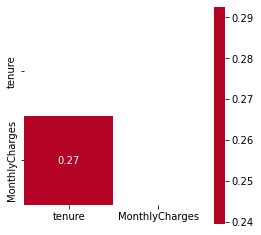

In [15]:
plt.figure(figsize=(4,4))
corr_df = df.corr(method='spearman')
matrix = np.triu(corr_df)
sns.heatmap(data=corr_df, annot=True, cmap='coolwarm', center=0, mask = matrix, square='True')
plt.show()

Kita dapat melihat bahwa :
- Data `tenure` dan `MonthlyCharges` tidak terdistribusi normal.
- Keduanya juga tidak memiliki data outlier dilihat dari boxplot di atas
- Antra `tenure` dan `MonthlyCharges` memiliki korelasi positif dengan nilai 0.27 : hubungannya lemah

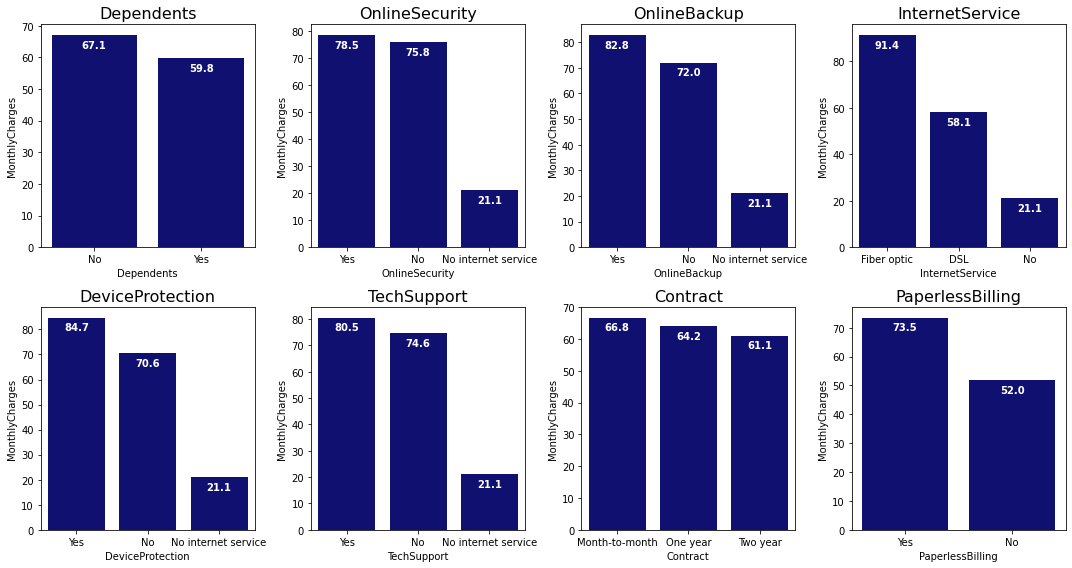

In [16]:
# barplot
plt.figure(figsize=(15, 8), facecolor='white')
plotnumber = 1
    
for feature in cat_features[:-1]:
    ax = plt.subplot(2,4, plotnumber)
    sns.barplot(data=df, y = 'MonthlyCharges', x=feature, ci=0, color='navy', order=df.groupby(feature)['MonthlyCharges'].mean().sort_values(ascending=False).index.values);
    plt.title(feature, fontsize=16)
    container = ax.containers[0]
    ax.bar_label(container , labels=[f'{x:,.1f}' for x in container.datavalues], label_type='edge', padding = -15, color="white", fontweight='bold')
    plt.tight_layout()
    plotnumber += 1


Dari grafik di atas kita dapat mengetahui bahwa :
- Rata-rata `MonthlyCharges` untuk pelanggan yang tidak memiliki `Dependents` cenderung lebih tinggi daripada pelanggan yang memiliki `Dependents`
- Rata-rata `MonthlyCharges` untuk pelanggan yang menggunakan `InternetService` Fiber optic cenderung lebih tinggi daripada pelanggan yang menggunakan DSL
- Rata-rata `MonthlyCharges` untuk pelanggan yang menggunakan layanan `OnlineSecurity, OnlineBackup, DeviceProtection` dan `TechSupport` cenderung lebih tinggi daripada pelanggan yang tidak menggunakan layanan tersebut. Hal ini wajar terjadi karena kita bisa mengasumsikan bahwa untuk menggunakan layanan tersebut pelanggan akan dikenakan biaya tambahan.
- Rata-rata `MonthlyCharges` untuk pelanggan dengan `Contract` Month-to-month cenderung lebih tinggi daripada pelanggan dengan `Contract` One year dan Two year. Kita dapat mengasumsikan bahwa pelanggan dengan kontrak yang bersifat jangka panjang (One year dan Two year) mendapatkan diskon atau tarif yang lebih murah dibandingkan pelanggan yang berlangganan untuk jangka pendek.
- Rata-rata `MonthlyCharges` untuk pelanggan yang menggunakan `PaperlessBilling` cenderung lebih tinggi daripada pelanggan yang tidak menggunakan.

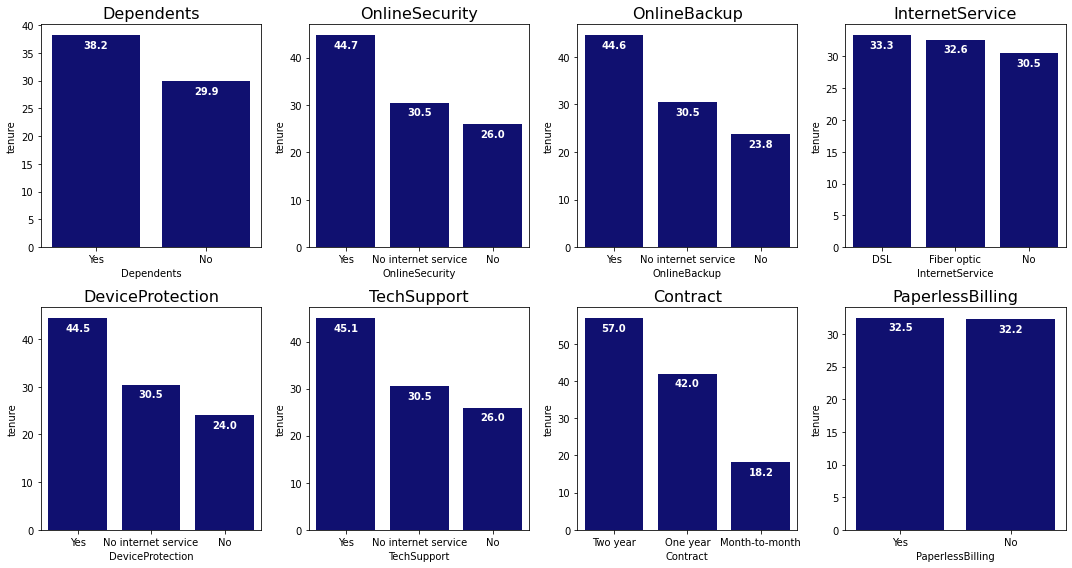

In [17]:
# barplot
plt.figure(figsize=(15, 8), facecolor='white')
plotnumber = 1
    
for feature in cat_features[:-1]:
    ax = plt.subplot(2,4, plotnumber)
    sns.barplot(data=df, y = 'tenure', x=feature, ci=0, color='navy', order=df.groupby(feature)['tenure'].mean().sort_values(ascending=False).index.values);
    plt.title(feature, fontsize=16)
    container = ax.containers[0]
    ax.bar_label(container , labels=[f'{x:,.1f}' for x in container.datavalues], label_type='edge', padding = -15, color="white", fontweight='bold')
    plt.tight_layout()
    plotnumber += 1

Dari grafik di atas kita dapat mengetahui bahwa :
- Rata-rata `tenure` untuk pelanggan yang tidak memiliki `Dependents` cenderung lebih tinggi daripada pelanggan yang memiliki `Dependents`
- Rata-rata `tenure` untuk pelanggan yang menggunakan `InternetService` DSL cenderung lebih tinggi daripada pelanggan yang menggunakan Fiber optic
- Rata-rata `tenure` untuk pelanggan yang menggunakan layanan `OnlineSecurity, OnlineBackup, DeviceProtection` dan `TechSupport` cenderung lebih tinggi daripada pelanggan yang tidak menggunakan layanan tersebut. 
- Rata-rata `tenure` untuk pelanggan dengan `Contract` Two year cenderung lebih tinggi daripada pelanggan dengan `Contract` One year dan Month-to-Month.
- Rata-rata `tenure` untuk pelanggan yang menggunakan `PaperlessBilling` maupun tidak, tidak begitu jauh berbeda.

#### Feature terhadap Target (Churn)

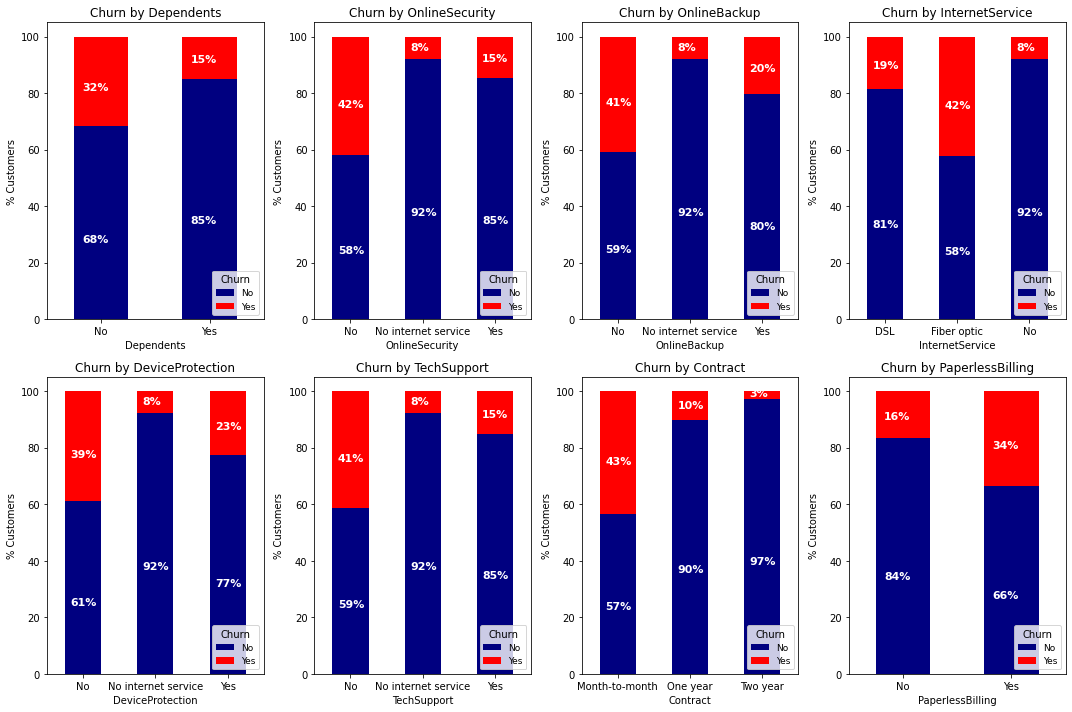

In [18]:
plt.figure(figsize=(15, 10), facecolor='white')
plotnumber = 1

for feature in cat_features[:-1]:

        column1 = feature

        # membuat table berdasarkan 2 kolom kategorikal
        groupby_table = df.groupby([column1,'Churn']).size().unstack()

        # fungsi untuk pelabelan dimana jika nilainya 0 tidak akan ditampilkan
        def show() :
            if height > 0 :
                return '{:.0f}%'.format(height)
            else :
                return '' 
        
        # subplot (letak grafik)
        ax = plt.subplot(2, 4, plotnumber)
        
        # Harga rumah berdasarkan feature 
        (groupby_table.T*100.0 / groupby_table.T.sum()).T.plot(kind='bar',
                                                                width = 0.5,
                                                                stacked = True,
                                                                rot = 0, 
                                                                ax = ax,
                                                                color = ['navy', 'red'])

        ax.legend(loc = 'lower right', prop={'size':9},title = 'Churn')
        ax.set_ylabel('% Customers')
        ax.set_title(f'Churn by {column1}',size = 12)

        # menambahkan label data pada stacked bar chart
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate(show(), (p.get_x()+0.15*width, p.get_y()+.4*height),
                        color = 'white',
                        weight = 'bold',
                        size = 11)
        
        plt.tight_layout();
        
        plotnumber += 1
    


Berdasarkan barplot diatas kita dapat menyimpulkan beberapa hal :
1. Pelanggan yang tidak memiliki `Dependent` lebih cenderung untuk berhenti berlangganan (churn) dibandingkan Pelanggan yang memiliki `Dependent`
2. Pelanggan yang `InternetService`nya menggunakan Fiber optic lebih cenderung untuk berhenti berlangganan (churn) dibandingkan `InternetService` yang lain.
3. Pelanggan yang tidak menggunakan layanan `OnlineSecurity, OnlineBackup, DeviceProtection` dan `TechSupport` lebih cenderung untuk berhenti berlangganan (churn) dibandingkan yang menggunakan.
4. Pelanggan yang `Contract`nya Month-to-month lebih cenderung untuk berhenti berlangganan (churn) dibandingkan `Contract` yang lain. Bahkan yang `Contract`nya Two year hanya memiliki persentase churn sekitar 3%.
5. Pelanggan yang menggunakan `PaperlessBilling` lebih cenderung untuk berhenti berlangganan (churn) dibandingkan dengan yang tidak.

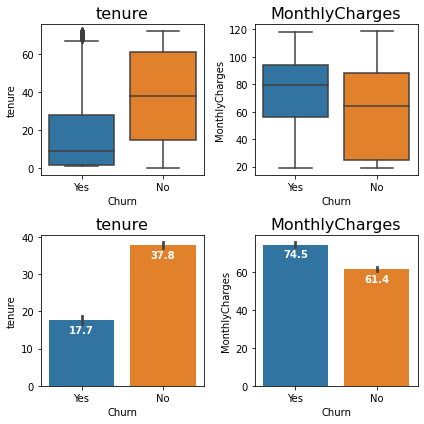

In [19]:
plt.figure(figsize=(6, 6), facecolor='white')
plotnumber = 1

for feature in num_feature:
    ax = plt.subplot(2,2, plotnumber)
    sns.boxplot(y=feature, x='Churn', data=df);
    plt.title(feature, fontsize=16)
    plt.tight_layout()
    plotnumber = plotnumber + 1

for feature in num_feature:
    ax = plt.subplot(2,2, plotnumber)
    sns.barplot(y=feature, x='Churn', data=df);
    plt.title(feature, fontsize=16)
    container = ax.containers[0]
    ax.bar_label(container , labels=[f'{x:,.1f}' for x in container.datavalues], label_type='edge', padding = -15, color="white", fontweight='bold')
    plt.tight_layout()
    plotnumber = plotnumber + 1

Terlihat dari boxplot dan barplot di atas bahwa :
- Pelanggan yang berhenti berlangganan (churn) memiliki median dan mean `tenure` yang lebih rendah dibandingkan pelanggan yang tidak berhenti.
- Pelanggan yang berhenti berlangganan (churn) memiliki median dan mean `MonthlyCharge` yang lebih tinggi dibandingkan pelanggan yang tidak berhenti.
- Kita dapat melihat terdapat outlier pada boxplot `tenure` untuk pelanggan yang berhenti berlangganan (`Churn`nya - Yes). Hal ini menunjukkan bahwa ada juga pelanggan yang berhenti berlangganan meskipun sudah menggunakan provider tersebut untuk waktu yang lama.

## **DATA PREPARATION**

In [20]:
# mengcopy dataframe terlebih dahulu agar tidak meubah dataframe aslinya
df_churn = df.copy()

### *CHANGE VALUE*

#### `Churn`

Kita ubah terlebih dahulu nilai pada kolom `Churn` dari 'Yes' dan 'No' menjadi 1 dan 0. Karena fokus utama kita adalah yang churn, maka :

Target :

0 : Tidak berhenti berlangganan (`Churn` == 'No')

1 : Berhenti berlangganan (`Churn` == 'Yes')

In [21]:
df_churn['Churn'] = np.where(df_churn['Churn']=='Yes',1,0)
df_churn['Churn'].unique()

array([1, 0])

Sekarang sudah terlihat bahwa nilai unik pada `Churn` kini menjadi 1 dan 0.

#### `OnlineSecurity, OnlineBackup, DeviceProtection` dan `TechSupport`

Jika kita perhatikan pada feature `OnlineSecurity, OnlineBackup, DeviceProtection` dan `TechSupport`, maka kita dapat melihat terdapat nilai unik 'No internet service' selain nilai 'Yes' dan 'No'.\
Padahal secara pengertian, data dengan nilai 'No internet service' pada kolom-kolom tersebut memiliki arti yang sama dengan nilai 'No' karena ketika pelanggan tidak menggunakan `InternetService`, maka pelanggan tersebut juga tidak menggunakan layanan `OnlineSecurity, OnlineBackup, DeviceProtection` dan `TechSupport` seperti terlihat pada tabel di bawah (tidak ada yang 'Yes').
.

In [22]:
# mengecek penggunaan layanan `OnlineSecurity, OnlineBackup, DeviceProtection` dan `TechSupport` ketika 'No' InternetService
df_no_internet = df_churn[df_churn['InternetService']=='No']

listItem = []
for col in df_no_internet.columns[2:7] :
    listItem.append( [col, df_no_internet[col].nunique(), df_no_internet.sort_values(col)[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Values'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Values
0,OnlineSecurity,1,[No internet service]
1,OnlineBackup,1,[No internet service]
2,InternetService,1,[No]
3,DeviceProtection,1,[No internet service]
4,TechSupport,1,[No internet service]


Oleh karenanya kita dapat ubah nilai 'No internet service' menjadi 'No' pada feature `OnlineSecurity, OnlineBackup, DeviceProtection` dan `TechSupport`

In [23]:
# mengubah 'No internet service' menjadi 'No' pada dataframe
df_churn = df_churn.replace('No internet service','No')

In [24]:
# mengecek nilai unik pada layanan `OnlineSecurity, OnlineBackup, DeviceProtection` dan `TechSupport` ketika 'No' InternetService
listItem = []
for col in df_churn.columns[2:7] :
    listItem.append( [col, df_churn[col].nunique(), df_churn.sort_values(col)[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Values'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Values
0,OnlineSecurity,2,"[No, Yes]"
1,OnlineBackup,2,"[No, Yes]"
2,InternetService,3,"[DSL, Fiber optic, No]"
3,DeviceProtection,2,"[No, Yes]"
4,TechSupport,2,"[No, Yes]"


Sekarang sudah terlihat bahwa nilai unik pada `OnlineSecurity, OnlineBackup, DeviceProtection` dan `TechSupport` hanya ada 'Yes' dan 'No'

### *MISSING VALUE*

In [25]:
# mengecek jumlah missing values
df.isna().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

Tidak terdapat Missing Values pada dataset. Sehingga kita tidak perlu menangani missing values.

### *OUTLIER*

Kita sudah cek bahwa secara umum, data pada kolom numerikal `tenure` dan `MonthlyCharges` tidak terdapat outlier.

Hal ini juga dapat kita lihat pada tabel di bawah bahwa seluruh data pada kedua feature resebut masih berada di dalam rentang Lower Fence (Q1 - 1.5 IQR) dan Upper Fence (Q3 + 1.5 IQR)

In [26]:
# mencari nilai lower dan upper fence pada masing-masing kolom

list_lower = []
list_upper = []
number_lower = []
number_inside = []
number_upper = []

for feature in num_feature: 
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    lower_fence = df[feature].quantile(0.25) - 1.5*IQR
    upper_fence = df[feature].quantile(0.75) + 1.5*IQR
    list_lower.append(lower_fence)
    list_upper.append(upper_fence)
    number_lower.append(len(df[df[feature]<lower_fence]))
    number_inside.append(len(df[(df[feature]>=lower_fence) & (df[feature]<=upper_fence)]))
    number_upper.append(len(df[df[feature]>upper_fence]))

outliers = pd.DataFrame({
    'Kolom' : num_feature,
    'Lower' : list_lower,
    'Upper' : list_upper,
    '# Lower' : number_lower,
    '# Inside' : number_inside,
    '# Upper' : number_upper,
})

outliers

,Kolom,Lower,Upper,# Lower,# Inside,# Upper
0,tenure,-60.00,124.00,0,4930,0
1,MonthlyCharges,-42.15,169.05,0,4930,0


In [27]:
# mencari nilai lower dan upper fence pada masing-masing kolom

list_kolom = []
list_lower = []
list_upper = []
number_lower = []
number_inside = []
number_upper = []

for feature in num_feature: 
    for churn in ['Yes', 'No'] :
        df_outlier = df[df['Churn']==churn]
        IQR = df_outlier[feature].quantile(0.75) - df_outlier[feature].quantile(0.25)
        lower_fence = df_outlier[feature].quantile(0.25) - 1.5*IQR
        upper_fence = df_outlier[feature].quantile(0.75) + 1.5*IQR
        list_kolom.append(f'{feature} - Churn = {churn}')
        list_lower.append(lower_fence)
        list_upper.append(upper_fence)
        number_lower.append(len(df_outlier[df_outlier[feature]<lower_fence]))
        number_inside.append(len(df_outlier[(df_outlier[feature]>=lower_fence) & (df_outlier[feature]<=upper_fence)]))
        number_upper.append(len(df_outlier[df_outlier[feature]>upper_fence]))

outliers = pd.DataFrame({
    'Kolom' : list_kolom,
    'Lower' : list_lower,
    'Upper' : list_upper,
    '# Lower' : number_lower,
    '# Inside' : number_inside,
    '# Upper' : number_upper,
})

outliers

,Kolom,Lower,Upper,# Lower,# Inside,# Upper
0,tenure - Churn = Yes,-37.00000,67.00000,0,1291,25
1,tenure - Churn = No,-54.00000,130.00000,0,3614,0
2,MonthlyCharges - Churn = Yes,-0.20625,150.84375,0,1316,0
3,MonthlyCharges - Churn = No,-69.10625,182.24375,0,3614,0


Kita juga sudah mengecek bahwa terdapat outlier pada boxplot `tenure` untuk pelanggan yang berhenti berlangganan (`Churn`nya - Yes). Hal ini menunjukkan bahwa ada juga pelanggan yang berhenti berlangganan meskipun sudah menggunakan provider tersebut untuk waktu yang lama.

Hal ini juga terlihat pada tabel di atas dimana pada kolom `tenure` untuk nilai `Churn` yang 'Yes' terdapat 25 data yang terletak di atas upper fence (outlier). Namun karena jumlahnya sedikit dan kita juga hendak mempelajari seluruh pelanggan yang berhenti berlangganan baik dengan `tenure` yang rendah maupun tinggi, maka data outlier tersebut tidak akan kita hilangkan.

### *ENCODING*

In [28]:
# menampilkan jumlah unik dan unique values untuk setiap kolom
pd.set_option('display.max_colwidth', None)
# data uni di tiap kolom
listItem = []
for col in cat_features[:-1] :
    listItem.append( [col, df_churn[col].nunique(), df_churn.sort_values(col)[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Values'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Values
0,Dependents,2,"[No, Yes]"
1,OnlineSecurity,2,"[No, Yes]"
2,OnlineBackup,2,"[No, Yes]"
3,InternetService,3,"[DSL, Fiber optic, No]"
4,DeviceProtection,2,"[No, Yes]"
5,TechSupport,2,"[No, Yes]"
6,Contract,3,"[Month-to-month, One year, Two year]"
7,PaperlessBilling,2,"[No, Yes]"


Sekarang mari kita melakukan fitur encoding untuk fitur-fitur categorical yang kita miliki.
Yang akan kita lakukan adalah :


1. Merubah fitur/kolom `Dependents` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
2. Merubah fitur/kolom `OnlineSecurity` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
3. Merubah fitur/kolom `OnlineBackup` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
4. Merubah fitur/kolom `InternetService` menggunakan One Hot Encoding, karena fitur ini memiliki churn rate yang berbeda-beda. Untuk nilainya akan kita urutkan berdasarkan churn rate tertinggi dimana 'Fiber optic' akan kita ubah menjadi 3, 'DSL' kita ubah menjadi 2, dan sisanya 'No' diubah menjadi 1.
5. Merubah fitur/kolom `DeviceProtection` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
6. Merubah fitur/kolom `TechSupport` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
7. Merubah fitur/kolom `Contract` menjadi integer 1-3 dengan Ordinal Encoding, karena fitur ini adalah lama kontrak dalam satuan bulan dan tahun. Untuk nilainya akan kita urutkan berdasarkan churn rate tertinggi dimana 'Month-to-month' akan kita ubah menjadi 3, 'One year' kita ubah menjadi 2, dan sisanya 'Two year' diubah menjadi 1.
8. Merubah fitur/kolom `PaperlessBilling` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.


In [29]:
# mapping untuk ordinal encoder

ordinal_mapping = [
    {'col':'InternetService', 'mapping':{None:0, 'Fiber optic':3, 'DSL':2, 'No':1}},
    {'col':'Contract', 'mapping':{None:0, 'Month-to-month':3, 'One year':2, 'Two year':1}}
]

In [30]:
transformer = ColumnTransformer([
    ('one_hot_encoder', OneHotEncoder(drop='first'), ['Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'PaperlessBilling']),
    ('ordinal', ce.OrdinalEncoder(cols=['InternetService', 'Contract'], mapping=ordinal_mapping), ['InternetService', 'Contract']),
], remainder='passthrough')

### *SCALING*

Mengingat dalam pembuatan model machine learning nantinya kita juga akan mencoba menggunakan algoritma Logistic Regression dan KNN maka kita akan menerapkan scaling.

Harapannya dengan memiliki fitur pada skala yang sama maka kinerja algoritma machine learning akan meningkat karena setiap fitur dapat berkontibusi sama pada target. Jika tidak dilakukan scaling maka variabel skala besar akan mendominasi fitur skala kecil khususnya untuk algoritma yang memperhitungkan jarak seperti KNN.

Kemudian karena data pada kolom numerikal `tenure` dan `MonthlyCharges` juga tidak terdapat outlier (berdasarkan boxplot di pada EDA), maka kita bisa menggunakan MinMaxScaler().

In [31]:
scaler = MinMaxScaler()

### *IMBALANCE DATA*

In [32]:
df_churn['Churn'].value_counts() / len(df_churn)

0    0.733063
1    0.266937
Name: Churn, dtype: float64

Kita dapat melihat bahwa dataset tidak seimbang (mild imbalance) karena proporsi kelas minoritas sebesar 26.69% berada dalam rentang 20-40% dari dataset ([sumber](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data)).\
Untuk mensiasati hal tersebut maka kita akan menerapkan metode resampling agar data kita memiliki distribusi kelas yang lebih seimbang.

Adapun metode yang akan dipakai adalah Synthetic Minority Over-sampling Technique for Nominal and Continuous (SMOTENC). Hal ini dikarenakan : 
- untuk menghindari terbuangnya data pada kelas mayoritas jika menggunakan undersampling sehingga dapat menghilangkan
informasi penting pada data tersebut. 
- untuk menghindari overfitting karena penduplikasian data yang telah ada sebelumnya sehingga pengklasifikasi terkena informasi yang sama jika menggunakan Random Oversampling.
- pada data kita terdapat fitur yang numerikal (continuous) and kategorikal (nominal).

In [33]:
df_churn.columns

Index(['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
       'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'MonthlyCharges', 'Churn'],
      dtype='object')

In [34]:
# define oversampling 
resample = SMOTENC(random_state=0, categorical_features=[0, 2, 3, 4, 5, 6, 7, 8]) #['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService', 
                                                                                    # 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling']
       

### *DEFINE X AND Y*

Selanjutnya kita definisikan feature dan targetnya :
- feature : `Dependents, tenure, OnlineSecurity, OnlineBackup, InternetService, DeviceProtection, TechSupport, Contract, PaperlessBilling, MonthlyCharges`
- target : `Churn`

In [35]:
# define fetures and target
X = df_churn.drop(columns = ['Churn'])
y = df_churn['Churn']

### *DATA SPLITTING*

Untuk pemodelan ini kita akan menggunakan test size = 0.2 sehingga data testing adalah sebesar 20% dari keseluruhan dataset.

Karena kita akan menggunakan Classification untuk memprediksi data atau label yang sifatnya kategorik, maka kita menggunakan stratify=y agar proporsi nilai Churn pada y_train dan y_test sama.

In [36]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2, stratify=y)

In [37]:
y_train.value_counts() / len(y_train)

0    0.733012
1    0.266988
Name: Churn, dtype: float64

In [38]:
y_test.value_counts() / len(y_test)

0    0.733266
1    0.266734
Name: Churn, dtype: float64

## **MODELING & EVALUATION**

In [39]:
## ML Algo
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
ada = AdaBoostClassifier(random_state=0)
grad = GradientBoostingClassifier(random_state=0)
cat = CatBoostClassifier(verbose=False,random_state=0)
xgb = XGBClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0)

In [40]:
# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

### *MODEL BENCHMARKING - DEFAULT HYPERPARAMETER : CROSS VALIDATION* 

In [41]:
# untuk menyatukan resampler dan function dari sklearn
from imblearn.pipeline import Pipeline

In [42]:
models = [logreg, knn, tree, rf, ada, grad, cat, xgb, lgbm]

list_mean_with_sampling = []
list_std_with_sampling = []
list_mean_without_sampling = []
list_std_without_sampling = []

for model in  models :

    # modeling with oversampling
    pipe_model_with_sampling = Pipeline([
        ('prep', transformer),
        ('scaler', scaler),
        ('resample', resample),
        ('algo', model)
    ])

    model_cv_with_sampling = cross_val_score(
        estimator = pipe_model_with_sampling,
        X = X_train,
        y = y_train,
        cv = skf,
        scoring = f2_score,
        n_jobs = -1
    )
    list_mean_with_sampling.append(model_cv_with_sampling.mean())
    list_std_with_sampling.append(model_cv_with_sampling.std())

    # modeling without oversampling

    pipe_model_without_sampling = Pipeline([
        ('prep', transformer),
        ('scaler', scaler),
        ('algo', model)
    ])

    model_cv_without_sampling = cross_val_score(
        estimator = pipe_model_without_sampling,
        X = X_train,
        y = y_train,
        cv = skf,
        scoring = f2_score,
        n_jobs = -1
    )
    list_mean_without_sampling.append(model_cv_without_sampling.mean())
    list_std_without_sampling.append(model_cv_without_sampling.std())

In [43]:
pd.DataFrame({
    'model' : ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'GradienBoost', 'CatBoost', 'XGBoost', 'LightGBM'],
    'mean_f2score_with_sampling' : list_mean_with_sampling,
    'mean_f2score_without_sampling' : list_mean_without_sampling,
    'std_f2score_with_sampling' : list_std_with_sampling,
    'std_f2score_without_sampling' : list_std_without_sampling,
}).sort_values('mean_f2score_with_sampling', ascending=False)

,model,mean_f2score_with_sampling,mean_f2score_without_sampling,std_f2score_with_sampling,std_f2score_without_sampling
0,Logistic Regression,0.711654,0.543034,0.024869,0.035596
4,AdaBoost,0.706649,0.553632,0.017432,0.030210
5,GradienBoost,0.693940,0.538216,0.022432,0.032712
6,CatBoost,0.673254,0.531903,0.014370,0.043191
8,LightGBM,0.658437,0.537022,0.034342,0.034078
7,XGBoost,0.638191,0.525906,0.035352,0.036745
1,KNN,0.623292,0.490340,0.023708,0.024599
3,Random Forest,0.576142,0.506034,0.027667,0.030850
2,Decision Tree,0.572197,0.503800,0.020326,0.016706


Terlihat bahwa model Logistic Regression adalah yang terbaik untuk f2score-nya dari setiap model yang menggunakan default hyperparameter.

Terlihat juga bahwa untuk rata-rata f2score dari validation set lebih baik setelah dilakukan oversampling dibandingkan tanpa oversampling. Hal tersebut menunjukkan bahwa teknik resampling menggunakan SMOTENC mampu meningkatkan performa algoritma klasifikasi dalam meminimalisir jumlah pelanggan yang aktualnya churn tetapi diprediksi tidak akan churn (False Negatif), sehingga nilai f2score-nya naik.

Mengingat hal tersebut sejalan dengan tujuan awal kita untuk membuat model yang dapat mengurangi customer churn dari perusahaan tersebut, khususnya jumlah pelanggan yang aktualnya churn tetapi diprediksi tidak akan churn (False Negatif), maka kita memilih menggunakan model yang menerapkan oversampling.

### *MODEL BENCHMARKING- DEFAULT HYPERPARAMETER : TRAIN & TEST DATA*

In [44]:
models = [logreg, knn, tree, rf, ada, grad, cat, xgb, lgbm]
score_f2_test = []
score_f2_train = []

def y_pred_func(model):
    estimator = Pipeline([
        ('prep', transformer),
        ('scaler', scaler),
        ('resample', resample),
        ('algo', model)
    ])
    
    estimator.fit(X_train,y_train)
    return estimator

for model in models:
    estimator = y_pred_func(model)
    y_pred_test = estimator.predict(X_test)
    y_pred_train = estimator.predict(X_train)
    score_f2_test.append(fbeta_score(y_test,y_pred_test, beta=2))
    score_f2_train.append(fbeta_score(y_train,y_pred_train, beta=2))

In [45]:
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'GradienBoost', 'CatBoost', 'XGBoost', 'LightGBM'],
             'f2 score (train set)': score_f2_train,
             'f2 score (validation set)': list_mean_with_sampling,
             'f2 score (test set)': score_f2_test}).set_index('model').sort_values(by='f2 score (validation set)',ascending=False)

,f2 score (train set),f2 score (validation set),f2 score (test set)
model,,,
Logistic Regression,0.717860,0.711654,0.718232
AdaBoost,0.724461,0.706649,0.701262
GradienBoost,0.738747,0.693940,0.663558
CatBoost,0.802658,0.673254,0.658858
LightGBM,0.798992,0.658437,0.643275
XGBoost,0.870920,0.638191,0.620384
KNN,0.771229,0.623292,0.638909
Random Forest,0.986905,0.576142,0.579710
Decision Tree,0.981326,0.572197,0.541142


Terlihat bahwa model Logistic Regression, AdaBoost dan GradientBoost memiliki hasil yang cukup stabil baik pada train set, validation maupun test set.

Sedangkan model lainnya cenderung mengalami overfitting dimana model memiliki performa yang baik pada training set tetapi masih memiliki performa yang buruk pada validation dan test set. Hal ini bisa terjadi dikarenakan model-model tersebut terlalu kompleks karena hyperparameternya masih kita biarkan sesuai default-nya.

Oleh karenanya kita akan coba tentukan benchmark model dengan melakukan tuning pada hyperparameter tertentu.

### *MODEL BENCHMARKING - TUNING 1 HYPERPARAMETER : CROSS VALIDATION*


Pada tahapan kali ini kita akan mencoba mengadjust hyperparameter pada setiap model, namun kita fokuskan pada hyperparameter yang paling penting saja.

Berdasarkan artikel [disini](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/), tidak semua hyperparameter pada model memiliki tingkat kepentingan yang sama. Beberapa hyperparameter memiliki efek besar pada perilaku dan kinerja algoritma machine learning. Oleh karenanya kita akan fokus untuk tuning 1 hyperparameter saja pada tiap model.

Hyperparameters yang akan kita coba tuning untuk masing-masing model diantaranya yaitu :
- Logistic Regression --> **solver** : [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
- KNN --> **n_neighbors** : [bilangan ganjil dari 1 - 21]
- Decision Tree --> **max_depth** : [dari 1 sampai 10]
- Random Forest --> **max_features** : [dari 1 sampai 5]
- AdaBoost --> **learning_rate** : [0.001, 0.01, 0.1]
- GradientBoost --> **learning_rate** : [0.001, 0.01, 0.1]
- CatBoost --> **scale_pos_weight** : [2, 3, 5, 10, 20, 30]
- XGBoost --> **scale_pos_weight** : [2, 3, 5, 10, 20, 30]
- LightGBM --> **scale_pos_weight** : [2, 3, 5, 10, 20, 30]

In [46]:
## hyperparameter dan model yang akan dipakai

param_logreg = {'algo__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
param_knn = {'algo__n_neighbors' : range(1,22,2)}
param_tree = {'algo__max_depth' : range(1,10,1)}
param_rf = {'algo__max_features' : range(1,6,1)}
param_ada = {'algo__learning_rate' : [0.001, 0.01, 0.1]}
param_grad = {'algo__learning_rate' : [0.001, 0.01, 0.1]}
param_cat = {'algo__scale_pos_weight' : [2, 3, 5, 10, 20, 30]}
param_xgb = {'algo__scale_pos_weight' : [2, 3, 5, 10, 20, 30]}
param_lgbm = {'algo__scale_pos_weight' : [2, 3, 5, 10, 20, 30]}

models = [logreg, knn, tree, rf, ada, grad, cat, xgb, lgbm]
params = [param_logreg, param_knn, param_tree, param_rf, param_ada, param_grad, param_cat, param_xgb, param_lgbm]

In [47]:
# menentukan best params dan best score untuk masing masing model

list_best_param = []
list_best_score = []

for model, param in zip(models,params):
    ## hyperparameter 
    hyperparam_space = param

    # GridSearch CV
    benchmark_model = Pipeline([
        ('prep', transformer),
        ('scaler', scaler),
        ('resample', resample),
        ('algo', model)
    ])

    grid_search = GridSearchCV(
        estimator = benchmark_model,
        param_grid=hyperparam_space,
        cv=skf,
        scoring=f2_score,
        n_jobs=-1,
    )

    grid_search.fit(X_train, y_train)
    list_best_param.append(grid_search.best_params_)
    list_best_score.append(grid_search.best_score_)

In [48]:
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'GradienBoost', 'CatBoost', 'XGBoost', 'LightGBM'],
             'best param': list_best_param,
             'best f2 score': list_best_score}).sort_values('best f2 score', ascending=False)

,model,best param,best f2 score
8,LightGBM,{'algo__scale_pos_weight': 10},0.747377
6,CatBoost,{'algo__scale_pos_weight': 10},0.745824
2,Decision Tree,{'algo__max_depth': 1},0.742595
4,AdaBoost,{'algo__learning_rate': 0.001},0.742595
7,XGBoost,{'algo__scale_pos_weight': 30},0.732464
5,GradienBoost,{'algo__learning_rate': 0.01},0.718878
0,Logistic Regression,{'algo__solver': 'liblinear'},0.713761
1,KNN,{'algo__n_neighbors': 21},0.676420
3,Random Forest,{'algo__max_features': 4},0.582682


Sekarang terlihat bahwa model Decision Tree (Interpretable AI) dan LightGBM (Explainable AI) adalah yang terbaik untuk f2_score-nya dari setiap model yang menggunakan tuning pada 1 hyperparameter.

### *MODEL BENCHMARKING- TUNING 1 HYPERPARAMETER : TRAIN & TEST DATA*

In [49]:
## ML Algo setelah tuning
logreg = LogisticRegression(solver = 'liblinear', random_state=0)
knn = KNeighborsClassifier(n_neighbors = 21)
tree = DecisionTreeClassifier(max_depth = 1, random_state=0)
rf = RandomForestClassifier(max_features = 4, random_state=0)
ada = AdaBoostClassifier(learning_rate = 0.001, random_state=0)
grad = GradientBoostingClassifier(learning_rate = 0.01, random_state=0)
cat = CatBoostClassifier(scale_pos_weight = 10, verbose=False,random_state=0)
xgb = XGBClassifier(scale_pos_weight = 30, random_state=0)
lgbm = LGBMClassifier(scale_pos_weight = 10, random_state=0)

In [50]:
models = [logreg, knn, tree, rf, ada, grad, cat, xgb, lgbm]
score_f2_test = []
score_f2_train = []

def y_pred_func(model):
    estimator = Pipeline([
        ('prep', transformer),
        ('scaler', scaler),
        ('resample', resample),
        ('algo', model)
    ])
    
    estimator.fit(X_train,y_train)
    return estimator

for model in models:
    estimator = y_pred_func(model)
    y_pred_test = estimator.predict(X_test)
    y_pred_train = estimator.predict(X_train)
    score_f2_test.append(fbeta_score(y_test,y_pred_test, beta=2))
    score_f2_train.append(fbeta_score(y_train,y_pred_train, beta=2))

In [51]:
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'AdaBoost', 'GradienBoost', 'CatBoost', 'XGBoost', 'LightGBM'],
             'f2 score (train set)': score_f2_train,
             'f2 score (validation set)': list_best_score,
             'f2 score (test set)': score_f2_test}).set_index('model').sort_values(by='f2 score (validation set)',ascending=False)

,f2 score (train set),f2 score (validation set),f2 score (test set)
model,,,
LightGBM,0.822913,0.747377,0.724138
CatBoost,0.803763,0.745824,0.723926
Decision Tree,0.742621,0.742595,0.717446
AdaBoost,0.742621,0.742595,0.717446
XGBoost,0.856515,0.732464,0.715206
GradienBoost,0.725765,0.718878,0.694540
Logistic Regression,0.718232,0.713761,0.721187
KNN,0.739093,0.676420,0.703018
Random Forest,0.986905,0.582682,0.577508


Terlihat bahwa model LightGBM merupakan model terbaik untuk Explainable ML dan Decision Tree erupakan model terbaik untuk Interpretable ML. Keduanya  memiliki hasil f2 score yang baik dan cukup stabil baik pada train set maupun test set. Artinya kedua model setelah dilakukan tuning pada salah satu hyperparameternya mampu meminimalisir jumlah pelanggan yang aktualnya churn tetapi diprediksi tidak akan churn (False Negatif) dan pelanggan yang aktualnya tidak churn tetapi diprediksi akan churn (False Positif) dengan lebih baik.

Adapun untuk model Random Forest cenderung mengalami overfitting dimana model memiliki performa yang sangat baik pada training set (f2 score mendekati 1) tetapi masih memiliki performa yang buruk pada test set.

Oleh karenanya kita akan jadikan Decision Tree dan LightGBM sebagai benchmark model kita.

Sekarang mari kita coba melakukan hyperparameter tuning kembali pada kedua model tersebut untuk mendapatkan hasil yang lebih baik lagi.

### *HYPERPARAMETER TUNING : DECISION TREE*

In [52]:
## hyperparameter untuk Decision Tree
hyperparam_space = {
    'algo__max_depth' : range(1,20,1),
    'algo__min_samples_split' : range (2, 200, 2),
    'algo__min_samples_leaf' : range (1, 50, 1)
}

# RandomizedSearch CV

benchmark_model = Pipeline([
    ('prep', transformer),
    ('scaler', scaler),
    ('resample', resample),
    ('algo', DecisionTreeClassifier(random_state=0))
])

random_search_tree = RandomizedSearchCV(
    estimator = benchmark_model,
    param_distributions=hyperparam_space,
    cv=skf,
    scoring=f2_score,
    n_jobs=-1,
    n_iter = 100,
    random_state = 0
)

random_search_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one_hot_encoder',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Dependents',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'PaperlessBilling']),
                                                                              ('ordinal',
                                                                               OrdinalEncoder(cols=...
                                             ('scaler', MinMaxScaler()),
                                             ('resample',
                                              SMOTENC(categorical_features=[0,
                                                                            2,
                                                                            3,
                                                                            4,
                                                                            5,
                                                                            6,
                                                                            7,
                                                                            8],
                                                      random_state=0)),
                                             ('algo',
                                              DecisionTreeClassifier(random_state=0))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'algo__max_depth': range(1, 20),
                                        'algo__min_samples_leaf': range(1, 50),
                                        'algo__min_samples_split': range(2, 200, 2)},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [53]:
random_search_tree.best_score_

0.7425950835299877

In [54]:
random_search_tree.best_params_

{'algo__min_samples_split': 182,
 'algo__min_samples_leaf': 21,
 'algo__max_depth': 2}

Hyperparameter terbaik Decision Tree dari hasil RandomSearch => `max_depth` = 2, `min_samples_split` = 182, `min_samples_leaf` = 21 dengan f2_score 0.742595. Nilai ini tidak berbeda dengan nilai sebelum tuning.

In [55]:
pd.DataFrame(random_search_tree.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__min_samples_split,param_algo__min_samples_leaf,param_algo__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
85,0.543376,0.018590,0.016170,0.000342,82,40,2,"{'algo__min_samples_split': 82, 'algo__min_samples_leaf': 40, 'algo__max_depth': 2}",0.757812,0.72663,0.730469,0.752143,0.745921,0.742595,0.01213,1
32,0.582895,0.019114,0.023300,0.004925,12,9,1,"{'algo__min_samples_split': 12, 'algo__min_samples_leaf': 9, 'algo__max_depth': 1}",0.757812,0.72663,0.730469,0.752143,0.745921,0.742595,0.01213,1
28,0.535669,0.028076,0.016513,0.001783,44,26,1,"{'algo__min_samples_split': 44, 'algo__min_samples_leaf': 26, 'algo__max_depth': 1}",0.757812,0.72663,0.730469,0.752143,0.745921,0.742595,0.01213,1
72,0.521329,0.009643,0.016287,0.005519,130,45,1,"{'algo__min_samples_split': 130, 'algo__min_samples_leaf': 45, 'algo__max_depth': 1}",0.757812,0.72663,0.730469,0.752143,0.745921,0.742595,0.01213,1
51,0.524797,0.016472,0.019196,0.003918,192,36,1,"{'algo__min_samples_split': 192, 'algo__min_samples_leaf': 36, 'algo__max_depth': 1}",0.757812,0.72663,0.730469,0.752143,0.745921,0.742595,0.01213,1


Dari tabel di atas juga terlihat bahwa 5 rata-rata skor f2_score tertinggi (dengan angka yang sama) didominasi oleh hyperparameter `max_depth` antara 1 dan 2. Sedangkan nilai `min_samples_split` masih cukup bervariasi antara 12 - 192, begitupun dengan `min_samples_leaf` cukup bervariasi antara 9 - 45. Hal tersebut menunjukkan bahwa skor f2_score yang tinggi dapat diperoleh dengan kedalaman pohon yang pendek pada Decision Tree.

Selanjutnya mari kita coba predict ke test set.

In [56]:
# model benchmark predict to test set
tree_benchmark = Pipeline([
    ('prep', transformer),
    ('scaler', scaler),
    ('resample', resample),
    ('algo', DecisionTreeClassifier(max_depth = 1, random_state=0))
])

tree_benchmark.fit(X_train, y_train)
y_pred_tree_benchmark = tree_benchmark.predict(X_test)
fbeta_score(y_test, y_pred_tree_benchmark, beta=2)

0.7174462705436158

In [57]:
# model after tuning predict to test set
tree_after_tuning = random_search_tree.best_estimator_
tree_after_tuning.fit(X_train, y_train)
y_pred_tree_tuned = tree_after_tuning.predict(X_test)
fbeta_score(y_test, y_pred_tree_tuned, beta=2)

0.7174462705436158

Terlihat bahwa model Decision Tree setelah kita tuning hyperparameternya memiliki nilai f2 score yang sama dengan model Benchmark pada test set.

### *HYPERPARAMETER TUNING : LIGHTGBM*

In [58]:
## hyperparameter untuk LightGBM
hyperparam_space = {
    'algo__scale_pos_weight' : [2, 3, 5, 10, 20, 30],
    'algo__learning_rate' : [0.001, 0.01, 0.1, 1],
    'algo__max_depth' : range(2,10,1),
}

# RandomizedSearch CV

benchmark_model = Pipeline([
    ('prep', transformer),
    ('scaler', scaler),
    ('resample', resample),
    ('algo', LGBMClassifier(random_state=0))
])

random_search_lgbm = RandomizedSearchCV(
    estimator = benchmark_model,
    param_distributions=hyperparam_space,
    cv=skf,
    scoring=f2_score,
    n_jobs=-1,
    n_iter = 50,
    random_state = 0
)

random_search_lgbm.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one_hot_encoder',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['Dependents',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'PaperlessBilling']),
                                                                              ('ordinal',
                                                                               OrdinalEncoder(cols=...
                                             ('scaler', MinMaxScaler()),
                                             ('resample',
                                              SMOTENC(categorical_features=[0,
                                                                            2,
                                                                            3,
                                                                            4,
                                                                            5,
                                                                            6,
                                                                            7,
                                                                            8],
                                                      random_state=0)),
                                             ('algo',
                                              LGBMClassifier(random_state=0))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'algo__learning_rate': [0.001, 0.01,
                                                                0.1, 1],
                                        'algo__max_depth': range(2, 10),
                                        'algo__scale_pos_weight': [2, 3, 5, 10,
                                                                   20, 30]},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=2))

In [59]:
random_search_lgbm.best_score_

0.7535540562715329

In [60]:
random_search_lgbm.best_params_

{'algo__scale_pos_weight': 5,
 'algo__max_depth': 6,
 'algo__learning_rate': 0.001}

Hyperparameter terbaik LightGBM dari hasil RandomSearch => `scale_pos_weight` = 5, `learning_rate` = 0.001, `depth` = 6 dengan f2 score 0.753554. Nilai ini naik dibandingkan dengan nilai sebelum tuning.

In [61]:
pd.DataFrame(random_search_lgbm.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__scale_pos_weight,param_algo__max_depth,param_algo__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,0.587199,0.021823,0.014397,0.003198,5,6,0.001,"{'algo__scale_pos_weight': 5, 'algo__max_depth': 6, 'algo__learning_rate': 0.001}",0.772762,0.731040,0.750958,0.753373,0.759637,0.753554,0.013562,1
49,0.508797,0.032238,0.014402,0.003202,3,4,0.01,"{'algo__scale_pos_weight': 3, 'algo__max_depth': 4, 'algo__learning_rate': 0.01}",0.758755,0.734127,0.756630,0.756757,0.758755,0.753005,0.009484,2
31,0.524794,0.014838,0.016001,0.005060,3,3,0.01,"{'algo__scale_pos_weight': 3, 'algo__max_depth': 3, 'algo__learning_rate': 0.01}",0.761035,0.737005,0.758860,0.760279,0.747734,0.752983,0.009332,3
32,0.535997,0.011315,0.019203,0.003920,2,2,0.1,"{'algo__scale_pos_weight': 2, 'algo__max_depth': 2, 'algo__learning_rate': 0.1}",0.759289,0.731908,0.751819,0.753425,0.763052,0.751899,0.010779,4
3,0.652453,0.026428,0.023899,0.005306,3,2,0.1,"{'algo__scale_pos_weight': 3, 'algo__max_depth': 2, 'algo__learning_rate': 0.1}",0.764431,0.729002,0.758052,0.743034,0.760279,0.750959,0.013142,5


Dari tabel di atas juga terlihat bahwa 5 rata-rata skor recall tertinggi didominasi oleh hyperparameter `learning_rate` sebesar 0.001 dan `scale_pos_weight` didominasi angka 30. Sedangkan `depth` masih cukup bervariasi antara 2 s.d 9. Hal tersebut menunjukkan bahwa skor recall yang tinggi lebih dipengaruhi oleh `learning_rate` dan `scale_pos_weight` pada LightGBM.

Selanjutnya mari kita coba predict ke test set.

In [62]:
# model benchmark predict to test set
lgbm_benchmark = Pipeline([
    ('prep', transformer),
    ('scaler', scaler),
    ('resample', resample),
    ('algo', LGBMClassifier(scale_pos_weight = 10, random_state=0))
])

lgbm_benchmark.fit(X_train, y_train)
y_pred_lgbm_benchmark = lgbm_benchmark.predict(X_test)
fbeta_score(y_test, y_pred_lgbm_benchmark, beta=2) 

0.7241379310344829

In [63]:
# model after tuning predict to test set
lgbm_after_tuning = random_search_lgbm.best_estimator_
lgbm_after_tuning.fit(X_train, y_train)
y_pred_lgbm_tuned = lgbm_after_tuning.predict(X_test)
fbeta_score(y_test, y_pred_lgbm_tuned, beta=2)

0.7342233009708737

Terlihat bahwa model LightGBM setelah kita tuning hyperparameternya memiliki nilai f2_score yang lebih tinggi (0.7342233) dari model Benchmark pada test set (0.7241379).

### *KOMPARASI : DECISION TREE DAN LIGHTGBM*

Secara umum, hasil pemodelan antara model Decision Tree dan LightGBM dapat dilihat sebagai berikut :

In [64]:
# membuat tabulasi f2 score
df_score = pd.DataFrame({
    'Decision Tree' : [list_best_score[2], random_search_tree.best_score_, fbeta_score(y_test, y_pred_tree_benchmark, beta=2), fbeta_score(y_test, y_pred_tree_tuned, beta=2)],
    'LightGBM' : [list_best_score[6], random_search_lgbm.best_score_, fbeta_score(y_test, y_pred_lgbm_benchmark, beta=2), fbeta_score(y_test, y_pred_lgbm_tuned, beta=2)]
})

In [65]:
# untuk label index
outside = ['Train Set', 'Train Set', 'Test Set', 'Test Set',]
inside = ['Benchmark Model', 'Tuning Model', 'Benchmark Model', 'Tuning Model']

# memasangkan item pada index yang sama dari 2 list
hier_index = list(zip(outside, inside))

# membuat multiindex 
multi = pd.MultiIndex.from_tuples(hier_index)


In [66]:
# mengubah lavel index lama menjadi multi-index yang telah kita buat di atas
df_score.index = multi
df_score

Decision Tree  LightGBM
Train Set Benchmark Model       0.742595  0.745824
          Tuning Model          0.742595  0.753554
Test Set  Benchmark Model       0.717446  0.724138
          Tuning Model          0.717446  0.734223

Terlihat bahwa :
- F2 Score pada Train Set baik untuk Benchmark Model maupun Model yang sudah di-tuning pada Decision Tree besarnya sama yaitu 0.742595.
- F2 Score pada Test Set baik untuk Benchmark Model maupun Model yang sudah di-tuning pada Decision Tree besarnya sama yaitu 0.717446. 
- F2 Score pada Train Set untuk Model LightGBM yang sudah di-tuning (0.753554) lebih tinggi dari Benchmark Model (0.745824)
- F2 Score pada Test Set untuk Model LightGBM yang sudah di-tuning (0.734223) lebih tinggi dari Benchmark Model (0.724138). 

Maka kita akan gunakan model Decision Tree yang telah di Tuning sebagai Interpretable ML kita dan model LightGBM yang telah di Tuning sebagai Explainable ML .

### *FINAL MODEL - DECISION TREE AS INTERPRETABLE ML*

Model terbaik untuk interpretable Machine Learning yang akan kita pakai adalah Decision Tree yang telah dituning.

Decision Tree adalah sebuah cara/pemikiran/pembuatan keputusan yang berbentuk sekumpulan simpul seperti pohon yang dapat memberikan suatu jawaban dari beberapa pilihan Tindakan. Biasanya decision tree dimulai dari satu node atau satu simpul. Kemudian node tersebut bercabang untuk memberikan pilihan-pilihan Tindakan yang lain. Selanjutnya node tersebut akan memiliki cabang-cabang baru. Dalam pembuatan node atau cabang baru akan terus di ulang sampai kriteria berhenti dipenuhi.

In [67]:
# menyimpan algoritma model Decision Tree terbaik sebagai best tree
best_tree = Pipeline([
    ('prep', transformer),
    ('resample', resample),
    ('algo', DecisionTreeClassifier(max_depth = 2, min_samples_split=182, min_samples_leaf=21, random_state=0))
])

best_tree.fit(X_train, y_train)
y_pred_best_tree = best_tree.predict(X_test)
fbeta_score(y_test, y_pred_best_tree, beta=2) 

0.7174462705436158

Pada model best_tree di atas terlihat bahwa meski tidak dilakukan scaling, score F2 pada test set masih sama di angka 0.717446. Hal ini menunjukkan bahwa scaling tidak berpengaruh terhadap performa model Decision Tree yang kita buat. Oleh karenanya metode scaling tidak kita terapkan pada model Decision Tree akhir kita karena dapat mempersulit untuk menginterpretasikan hasil yang diperoleh.

##### *`FEATURE IMPORTANCES`*

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model Decision Tree kita

In [68]:
# mendapatkan nama fitur dari transformer
names = transformer.get_feature_names()
names

c:\Users\mzulfikarmuslim\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['one_hot_encoder__x0_Yes',
 'one_hot_encoder__x1_Yes',
 'one_hot_encoder__x2_Yes',
 'one_hot_encoder__x3_Yes',
 'one_hot_encoder__x4_Yes',
 'one_hot_encoder__x5_Yes',
 'ordinal__InternetService',
 'ordinal__Contract',
 'tenure',
 'MonthlyCharges']

In [69]:
columns = ['Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'PaperlessBilling']
codes = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']
list_name = []

# mengganti variable x0,..., x5 menjadi nama kolomnya
for i, (code, column) in enumerate(zip(codes,columns)):
    list_name.append(names[i].replace(code, column))

# menambahkan  'ordinal__InternetService', 'ordinal__Contract', 'tenure', 'MonthlyCharges' 
list_name.extend(names[6:])
list_name


['one_hot_encoder__Dependents_Yes',
 'one_hot_encoder__OnlineSecurity_Yes',
 'one_hot_encoder__OnlineBackup_Yes',
 'one_hot_encoder__DeviceProtection_Yes',
 'one_hot_encoder__TechSupport_Yes',
 'one_hot_encoder__PaperlessBilling_Yes',
 'ordinal__InternetService',
 'ordinal__Contract',
 'tenure',
 'MonthlyCharges']

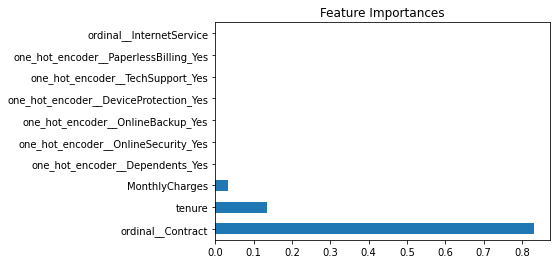

In [70]:
coef1 = pd.Series(best_tree['algo'].feature_importances_, list_name).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Terlihat bahwa ternyata untuk model Decision Tree kita, fitur/kolom `Contract` adalah yang paling penting, kemudian diikuti dengan `tenure` dan `MonthlyCharges`. Sedangkan fitur seperti `Dependents, OnlineSecurity, OnlineBackup, InternetService, DeviceProtection, TechSupport,` dan `PaperlessBilling` dianggap tidak begitu penting.

##### *`PLOT TREE`*

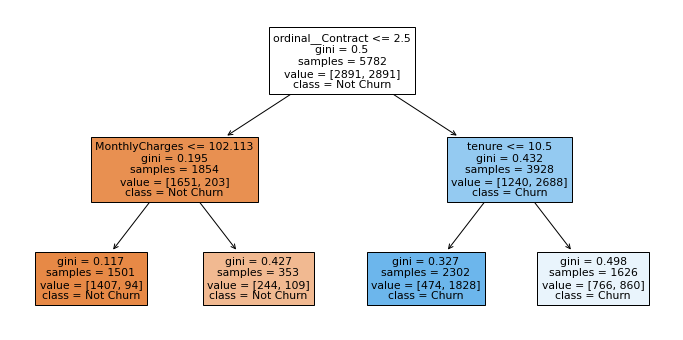

In [71]:
plt.figure(figsize=(12,6))

plot_tree(
    best_tree['algo'],
    feature_names = list_name,
    filled = True,
    class_names = ['Not Churn', 'Churn']
        );

`Contract` (sesuai encoding):

3 : 'Month-to-month'\
2 : 'One year'\
1 : 'Two year' 

Interpretasi

1. Jika ada pelanggan dengan `Contract` Two year atau One Year dan membayar `Monthly Charges` <= 102.11, maka pelanggan tersebut akan bertahan (Not Churn)
2. Jika ada pelanggan dengan `Contract` Two year atau One Year dan membayar `Monthly Charges` > 102.11, maka pelanggan tersebut akan bertahan (Not Churn)
1. Jika ada pelanggan dengan `Contract` 'Month-to-Month' dan memiliki `tenure` <= 10.5 bulan, maka pelanggan tersebut akan berhenti berlangganan (Churn)
2. Jika ada pelanggan dengan `Contract` 'Month-to-Month' dan memiliki `tenure` > 10.5 bulan, maka pelanggan tersebut akan berhenti berlangganan (Churn)

Dari interpretasi tersebut juga kita dapat melihat bahwa pada model Decision Tree yang telah kita buat, secara umum model tersebut mengklasifikasikan pelanggan berdasarkan kontraknya dimana pelanggan dengan `Contract` 'Month-to-Month' diklasifikasikan sebagai Churn, sedangkan pelanggan dengan `Contract` Two year atau One Year diklasifikasikan sebagai Not Churn.

Hal ini cukup konsisten dengan feature importance yang telah kita lihat sebelumnya bahwa fitur/kolom `Contract` adalah yang paling penting.

##### *`CONFUSION MATRIX`*

<AxesSubplot:>

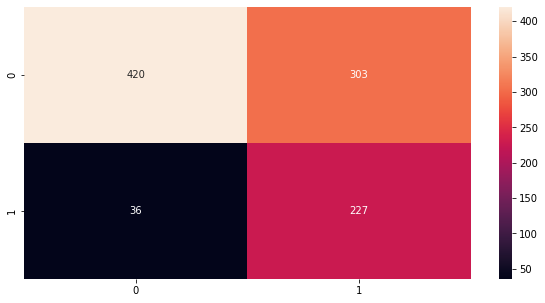

In [72]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred_best_tree), annot=True, fmt=".0f")

Berdasarkan confusion matrix pada test set di atas terlihat bahwa dengan model Decision Tree yang telah kita buat didapati:
- Jumlah pelanggan yang aktualnya churn dan diprediksi akan churn (True Positive) : 227 orang
- Jumlah pelanggan yang aktualnya churn tetapi diprediksi tidak akan churn (False Negative) : 36 orang
- Jumlah pelanggan yang aktualnya tidak churn dan diprediksi tidak akan churn (True Negative) : 420 orang
- Jumlah pelanggan yang aktualnya tidak churn tetapi diprediksi akan churn (False Positive) : 303 orang
- Jumlah pelanggan yang diprediksi akan churn sebanyak 303 + 227 = 530 orang
- Jumlah pelanggan yang diprediksi tidak akan churn sebanyak 420 + 36 = 456 orang


In [73]:
# mengecek hasil prediksi berdasarkan Contract
df_check = X_test.copy()
df_check['Prediction'] = y_pred_best_tree

df_check.pivot_table(
    index = 'Contract',
    columns = 'Prediction',
    values = 'MonthlyCharges',
    aggfunc=len
).fillna(0)


Prediction,0,1
Contract,,
Month-to-month,0.0,530.0
One year,209.0,0.0
Two year,247.0,0.0


Kita juga bisa melihat bahwa jumlah pelanggan yang diprediksi akan churn sebesar 530 orang tersebut semuanya berasal dari `Contract` Month-to-month. Hal ini konsisten dengan penjelasan pada plot tree sebelumnya dimana secara umum model tersebut mengklasifikasikan pelanggan berdasarkan kontraknya dimana pelanggan dengan `Contract` 'Month-to-Month' diklasifikasikan sebagai Churn, sedangkan pelanggan dengan `Contract` Two year atau One Year diklasifikasikan sebagai Not Churn

In [74]:
# score

print('Recall:', recall_score(y_test, y_pred_best_tree))
print('Precision:', precision_score(y_test, y_pred_best_tree))
print('F2 score:', fbeta_score(y_test, y_pred_best_tree, beta=2))
print('Accuracy:', accuracy_score(y_test, y_pred_best_tree))

Recall: 0.8631178707224335
Precision: 0.42830188679245285
F2 score: 0.7174462705436158
Accuracy: 0.6561866125760649


**Recall**

Recall menggambarkan berapa banyak jumlah aktual positif yang dapat diprediksi oleh model. Dalam kasus ini, false negative berarti pelanggan yang diprediksi tidak churn, namun aktualnya churn. Itu berarti, nilai recall merepresentasikan 'dari semua pelanggan yang aktualnya churn, berapa orang yang diklasifikasikan churn?'

Nilai recall 86.3% artinya, dari total pelanggan yang aslinya churn (263 orang), 86.3%-nya berhasil diprediksi dengan benar (227 orang)

Recall cocok digunakan jika cost untuk False Negative dinilai tinggi. Jika kita menggunakan metric recall, itu berarti kita berusaha untuk meminimalkan jumlah false negative yang dihasilkan oleh model, seperti dalam kasus ini kita minimalkan menjadi hanya 36 orang saja. 

**Precision**

Kita sudah melihat bahwa seluruh pelanggan dengan `Contract` 'Month-to-Month' diklasifikasikan sebagai Churn. Sehingga ada pelanggan dengan `Contract` 'Month-to-Month' yang aktualnya tidak churn, kita prediksikan churn (False Positive) sebanyak 303 orang. Kita menyadari bahwa ada trade off antara precision dan recall.

Nilai precision 42.8% artinya, dari total pelanggan yang diklasifikasikan churn (530 orang), hanya 42.8%-nya yang berhasil terprediksi dengan benar (227 orang).

**F2-score**

Metrik F2-score menggambarkan rata-rata harmonik dari nilai precision dan recall. Dengan menetapkan nilai beta = 2 , kita menganggap recall dua kali lebih penting daripada precision.
Nilai F2-Score didapat dari (5 * Precision * Recall) / (4 * Precision + Recall) = 5 x 42.8% x 86.3% / (4 * 42.8% + 86.3%) = 71.74%

**Accuracy**

Nilai accuracy 65.6% artinya, dari keseluruhan pelanggan yang dites (986 orang), 65.6%-nya berhasil berhasil diprediksi dengan benar (647 orang)

##### *`COST ESTIMATION`*

Berdasarkan asumsi yang telah disampaikan pada bagian Business Understanding, kita asumsikan dampak biayanya sebagai berikut :
- Biaya retensi per pelanggan --> $3.56 per bulan per pelanggan
- Asumsi persentase customer yang tetap bertahan (tidak jadi churn) akibat program retensi : 40% ([sumber](https://jungleworks.com/how-to-reduce-churn-rate-and-increase-customer-retention/))
- Biaya akibat kehilangan pelanggan (Churn) -->  $82.67 per bulan per pelanggan (total pendapatan yang hilang dan biaya Customer Acquisition Cost)

Jumlah pelanggan untuk dasar perhitungan :
- Pelanggan yang diberikan program retensi adalah seluruh pelanggan yang diprediksi akan Churn = TP + FP = 530 orang
- Pelanggan yang tetap bertahan (tidak jadi churn) akibat program retensi = 40% x TP = 40% x 227 = 91 orang
- Pelanggan yang churn = FN + TP - Pelanggan yang tetap bertahan (tidak jadi churn) akibat program retensi = 36 + 227 - 91 = 172 orang

Cost Estimation
- 530 orang x $3.56 per bulan per pelanggan + 172 orang x $82.67 per bulan per pelanggan = ($1886.8 + $14219.24)/bulan = $16106.04 per bulan

Maka kerugiannya sekitar $16106.04 per bulan untuk 986 pelanggan.

### *FINAL MODEL - LightGBM AS EXPLAINABLE ML*

Model terbaik untuk interpretable Machine Learning yang akan kita pakai adalah LightGBM yang telah dituning.

LightGBM adalah algoritma versi Gradient Boosting lain yang menggunakan leaf-wise algorithm untuk menumbuhkan Decision Tree secara vertikal. Leaf-wise algorithm ini bekerja dengan menambah cabang hingga tidak bisa dipecah lagi atau mencapai kedalaman maksimumnya. Gradientbased One-Side Sampling (GOSS) dan Exclusive Feature Bundling (EFB) digunakan untuk menangani data dan fitur dengan jumlah besar. 

GOSS digunakan oleh LGBM untuk mengurangi jumlah instance data dan menjaga akurasi untuk Decision Tree saat training. Hal ini dilakukan dengan menyimpan instance dengan gradient besar dan membuang instance dengan gradient kecil secara acak. Kemudian, telah dibuktikan bahwa perlakuan ini dapat menghasilkan estimasi gain yang lebih akurat daripada sampling acak seragam, dengan target sampling rate yang sama, terutama ketika nilai information gain memiliki rentang yang besar.

Sedangkan, LGBM menggunakan EFB untuk mengatasi sparsity dalam dataset. EFB menggabungkan fitur-fitur dan menghasilkan fitur yang lebih sedikit, namun tetap mempertahankan fitur yang penting.

In [75]:
# menyimpan algoritma model LightGBM terbaik sebagai best lgbm
best_lgbm = Pipeline([
    ('prep', transformer),
    ('resample', resample),
    ('algo', LGBMClassifier(scale_pos_weight = 5, learning_rate = 0.01, max_depth = 6, random_state=0))
])

best_lgbm.fit(X_train, y_train)
y_pred_best_lgbm = best_lgbm.predict(X_test)
fbeta_score(y_test, y_pred_best_lgbm, beta=2) 

0.7444168734491315

Pada model best_lgbm di atas terlihat bahwa ketika tidak dilakukan scaling, score F2 pada test set menjadi lebih baik yaitu 0.74441687 (dari sebelumnya 0.734223). Hal ini menunjukkan bahwa scaling tidak berpengaruh terhadap performa model LightGBM yang kita buat seperti pada model Decision Tree sebelumnya. Hal ini dikarenakan base learner pada algoritma LightGBM pun menggunakan Decision Tree di dalamnya sehingga scaling tidak mempengaruhi performa model.

##### *`FEATURE IMPORTANCES`*

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model LightGBM kita

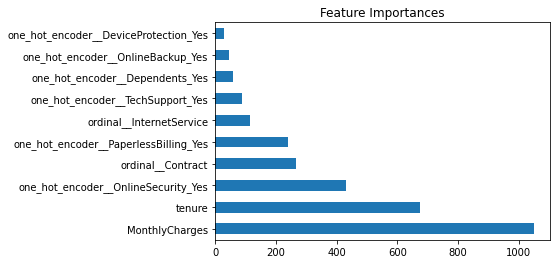

In [76]:
coef1 = pd.Series(best_lgbm['algo'].feature_importances_, list_name).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Terlihat bahwa ternyata untuk model Decision Tree kita, fitur/kolom `MonthlyCharges` adalah yang paling penting, kemudian diikuti dengan `tenure`, `OnlineSecurity`, `Contract` dan `PaperlessBilling`. Sedangkan fitur seperti `Dependents, OnlineBackup`, dan `DeviceProtection` dianggap tidak begitu penting.

Hal ini cukup berbeda dengan model Decision Tree kita sebelumnya, dimana fitur yang pentingnya hanya `Contract`, `tenure`, dan `Monthly_Charges`

##### *`SHAPLEY VALUE OF EXPLANATIONS (SHAP)`*

In [77]:
trans_resample = Pipeline([
    ('prep', transformer),
    ('resample', resample)
])

X_train_over, y_train_over = trans_resample.fit_resample(X_train, y_train)

In [78]:
best_lgbm['algo']

LGBMClassifier(learning_rate=0.01, max_depth=6, random_state=0,
               scale_pos_weight=5)

c:\Users\mzulfikarmuslim\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


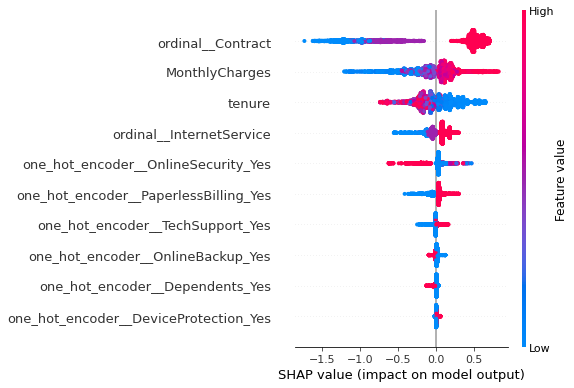

In [79]:
import shap

explainer = shap.TreeExplainer(best_lgbm['algo'])
shap_values = explainer.shap_values(X_train_over)

shap.summary_plot(shap_values[1], X_train_over, feature_names = list_name)


In [80]:
ordinal_mapping

[{'col': 'InternetService',
  'mapping': {None: 0, 'Fiber optic': 3, 'DSL': 2, 'No': 1}},
 {'col': 'Contract',
  'mapping': {None: 0, 'Month-to-month': 3, 'One year': 2, 'Two year': 1}}]

Berdasarkan SHAP value, kita dapat melihat bahwa fitur yang paling penting diantaranya:
- `Contract`
- `MonthlyCharges`
- `tenure`
- `InternetService`
- `OnlineSecurity`

Hal ini sedikit berbeda dengan hasil berdasarkan feature importance

Dan fitur yang paling tidak penting yaitu:
- `DeviceProtection`
- `Dependents`

**Interpretasi**

- Pelanggan dengan `Contract` Month-to-month (warna merah - 3), cenderung memiliki kemungkinan Churn yang lebih tinggi. Sedangkan semakin panjang `Contract` One-year (warna ungu - 2) dan Two-year (warna biru - 1), maka semakin besar kemungkinan untuk Not Churn.
- Semakin tinggi `MonthlyCharges` (warna merah), semakin besar kemungkinan pelanggan untuk Churn.
- Semakin pendek `tenure` (warna biru), semakin besar kemungkinan pelanggan untuk Churn
- Pelanggan dengan `InternetService` Fiber optic (warna merah - 3), cenderung memiliki kemungkinan Churn yang lebih tinggi dibandingkan dengan pelanggan yang menggunakan `InternetService` DSL atau No. Bahkan pelanggan tanpa `InternetService` cenderung untuk Not Churn.
- Pelanggan tanpa `OnlineSecurity` (warna biru - 0), cenderung memiliki kemungkinan Churn yang lebih tinggi dibandingkan yang menggunakan `OnlineSecurity`.

Hasil ini cukup konsisten dengan hasil analisa kita pada bagian EDA.

##### *`SHAPLEY VALUE OF EXPLANATIONS (SHAP) PER OBSERVATION FEATURE`*

In [81]:
# Start js (must have)
shap.initjs()

In [82]:
def shap_plot(j,model,S):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)[1]
    p = shap.force_plot(explainerModel.expected_value[1], shap_values_Model[j], S.iloc[[j]])
    return(p)

Mari kita coba observasi  ke 2 data dari dataset, untuk mempelajari bagaimana setiap fitur berkontribusi untuk memprediksi target berdasarkan skornya. Mari kita uji pada indeks ke 0 dan 4

In [83]:
X_test_df = pd.DataFrame(best_lgbm[0].transform(X_test), columns=list_name)
X_test_df.iloc[[0,4]]

,one_hot_encoder__Dependents_Yes,one_hot_encoder__OnlineSecurity_Yes,one_hot_encoder__OnlineBackup_Yes,one_hot_encoder__DeviceProtection_Yes,one_hot_encoder__TechSupport_Yes,one_hot_encoder__PaperlessBilling_Yes,ordinal__InternetService,ordinal__Contract,tenure,MonthlyCharges
0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,62.0,115.55
4,0.0,0.0,1.0,1.0,0.0,1.0,3.0,3.0,49.0,103.70


In [84]:
#target 
y_test.iloc[[0,4]]

1654    0
2668    1
Name: Churn, dtype: int32

In [85]:
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Churn' if y_test.iloc[0] == 1 else 'Not Churn')} from y_test")

shap_plot(0,best_lgbm['algo'],X_test_df)

The prediction must predict this passenger is: Not Churn from y_test


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Baseline valuenya adalah 0.4989. Pelanggan dengan index 0 memiliki risiko terprediksi yang lebih rendah sebesar -1.05. `Contract` Two year, tidak menggunakan `PaperlessBilling`, penggunaan `OnlineSecurity` dan `tenure` = 62 menurunkan prediksi risiko Churn. `MonthlyCharges`=115.5 dan `InternetService`nya menggunakan Fiber optic menaikkan risiko. 

Model LightGBM memprediksi pelanggan dengan index 0 sebagai `Not Churn` karena **output value < 0**.

In [86]:
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Churn' if y_test.iloc[4] == 1 else 'Not Churn')} from y_test")

shap_plot(4,best_lgbm['algo'],X_test_df)

The prediction must predict this passenger is: Churn from y_test


Pelanggan dengan index 4 memiliki risiko terprediksi yang lebih tinggi sebesar 1.19. Risiko Churn meningkat karena pengaruh  `Contract`nya Month-to-month, `MonthlyCharges`=103.7 dan `InternetService`nya menggunakan Fiber optic, sedangkan `tenure` = 49 mengurangi risiko. 

Model LightGBM memprediksi pelanggan dengan index 4 sebagai `Churn` karena **output value > 0**.

##### *`LOCAL INTERPRETABLE MODEL-AGNOSTIC EXPLANATION (LIME)`*

In [87]:
import lime
from lime import lime_tabular

# Explainer based
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_over),
    feature_names=list_name,
    class_names=['Not Churn', 'Churn'],
    mode='classification'
)

**Explain Feature based on Pyplot**

The prediction must predict this passenger is: Not Churn from y_test


''

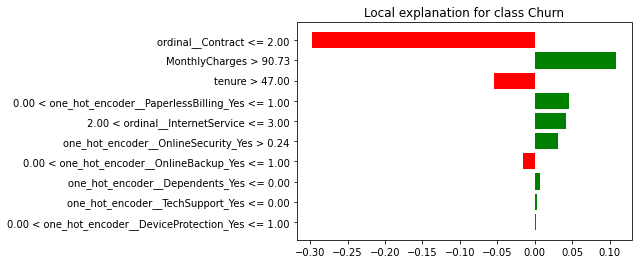

In [88]:
# Try to the observation 6
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Churn' if y_test.iloc[6] == 1 else 'Not Churn')} from y_test")

exp = explainer.explain_instance(X_test_df.iloc[6], 
                                 best_lgbm['algo'].predict_proba, 
                                 num_features=10)
exp.as_pyplot_figure()
;

**Interpretasi**

- Pada pelanggan dengan index 6, `Contract` <=2 (One year atau Two year) yang dimiliki cenderung mendorong orang tersebut untuk Not Churn.
- Sedangkan `MonthlyCharges` > 90.73 dapat menjadi faktor yang mendorong untuk Churn.
- `tenure` > 47 bulan akan meminimalisir kemungkinan pelanggan ini (index 6) untuk Churn

##### *`CONFUSION MATRIX`*

<AxesSubplot:>

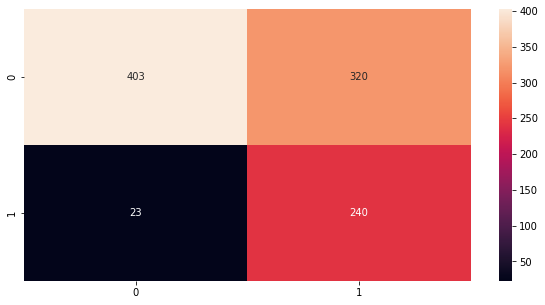

In [89]:
plt.figure(figsize=(10,5))
sns.heatmap(confusion_matrix(y_test, y_pred_best_lgbm), annot=True, fmt=".0f")

Berdasarkan confusion matrix pada test set di atas terlihat bahwa dengan model LightGBM yang telah kita buat didapati:
- Jumlah pelanggan yang aktualnya churn dan diprediksi akan churn (True Positive) : 240 orang
- Jumlah pelanggan yang aktualnya churn tetapi diprediksi tidak akan churn (False Negative) : 23 orang
- Jumlah pelanggan yang aktualnya tidak churn dan diprediksi tidak akan churn (True Negative) : 403 orang
- Jumlah pelanggan yang aktualnya tidak churn tetapi diprediksi akan churn (False Positive) : 320 orang
- Jumlah pelanggan yang diprediksi akan churn sebanyak 320 + 240 = 560 orang
- Jumlah pelanggan yang diprediksi tidak akan churn sebanyak 403 + 23 = 426 orang

In [90]:
# score
print('Recall:', recall_score(y_test, y_pred_best_lgbm))
print('Precision:', precision_score(y_test, y_pred_best_lgbm))
print('F2 score:', fbeta_score(y_test, y_pred_best_lgbm, beta=2))
print('Accuracy:', accuracy_score(y_test, y_pred_best_lgbm))

Recall: 0.9125475285171103
Precision: 0.42857142857142855
F2 score: 0.7444168734491315
Accuracy: 0.652129817444219


**Recall**

Nilai recall 91.25% artinya, dari total pelanggan yang aslinya churn (263 orang), 91.25%-nya berhasil diprediksi dengan benar (240 orang)

**Precision**

Nilai precision 42.86% artinya, dari total pelanggan yang diklasifikasikan churn (560 orang), hanya 42.86%-nya yang berhasil terprediksi dengan benar (240 orang).

**F1-score**

Nilai F2-Score didapat dari (5 * Precision * Recall) / (4 * Precision + Recall) = 5 x 42.86% x 91.25% / (4 * 42.86% + 91.25%) = 74.44%

**Accuracy**

Nilai accuracy 65.21% artinya, dari keseluruhan pelanggan yang dites (986 orang), 65.21%-nya berhasil berhasil diprediksi dengan benar (643 orang)

##### *`COST ESTIMATION`*

Berdasarkan asumsi yang telah disampaikan pada bagian Business Understanding, kita asumsikan dampak biayanya sebagai berikut :
- Biaya retensi per pelanggan --> $3.56 per bulan per pelanggan
- Asumsi persentase customer yang tetap bertahan (tidak jadi churn) akibat program retensi : 40% ([sumber](https://jungleworks.com/how-to-reduce-churn-rate-and-increase-customer-retention/))
- Biaya akibat kehilangan pelanggan (Churn) -->  $82.67 per bulan per pelanggan (total pendapatan yang hilang dan biaya Customer Acquisition Cost)

Jumlah pelanggan untuk dasar perhitungan :
- Pelanggan yang diberikan program retensi adalah seluruh pelanggan yang diprediksi akan Churn = TP + FP = 560 orang
- Pelanggan yang tetap bertahan (tidak jadi churn) akibat program retensi = 40% x TP = 40% x 240 = 96 orang
- Pelanggan yang churn = FN + TP - Pelanggan yang tetap bertahan (tidak jadi churn) akibat program retensi = 23 + 240 - 96 = 167 orang

Cost Estimation
- 560 orang x $3.56 per bulan per pelanggan + 167 orang x $82.67 per bulan per pelanggan = ($1993.6 + $13805.89)/bulan = $15799.49 per bulan

Maka kerugiannya sekitar $15799.49 per bulan untuk 986 pelanggan.

##### *`COST ESTIMATION TANPA MACHINE LEARNING`*

Saat kita tidak menggunakan machine learning, kita tidak dapat memprediksi pelanggan yang akan Churn atau tidak. Dampaknya adalah kita cenderung untuk memberi program retensi kepada seluruh Pelanggan.

Jumlah pelanggan untuk dasar perhitungan :
- Pelanggan yang diberikan program retensi adalah seluruh pelanggan yang diprediksi akan Churn = TP + FP = 986 orang
- Pelanggan yang tetap bertahan (tidak jadi churn) akibat program retensi = 40% x TP = 40% x 263 = 105 orang
- Pelanggan yang churn = FN + TP - Pelanggan yang tetap bertahan (tidak jadi churn) akibat program retensi = 0 + 263 - 105 = 158 orang

Cost Estimation
- 986 orang x $3.56 per bulan per pelanggan + 158 orang x $82.67 per bulan per pelanggan = ($3510.16 + $13061.86)/bulan = $16572.02 per bulan

Maka kerugiannya sekitar $16572.02 per bulan untuk 986 pelanggan bila kita tidak menggunakan machine learning.



## **CONCLUSION & RECOMMENDATION**

#### *CONCLUSION*

- Metric utama yang akan kita gunakan adalah f2_score, karena recall kita anggap dua kali lebih penting daripada precision.
    <br>
    <br>
- Berdasarkan hyperparameter tuning, parameter terbaik yang dapat digunakan untuk benchmark model Decision Tree adalah :
    - max_depth = 2 
    - min_samples_split=182
    - min_samples_leaf=21
    <br>
    <br>
- Berdasarkan pemodelan Decision Tree, fitur/kolom `Contract` adalah yang paling penting dan berpengaruh terhadap target (Churn), kemudian diikuti dengan `tenure` dan `MonthlyCharges`.
    <br>
    <br>
- Interpretasi pada plot tree dari Decision Tree adalah sebagai berikut :
    - Jika ada pelanggan dengan `Contract` Two year atau One Year dan membayar `Monthly Charges` <= 102.11, maka pelanggan tersebut akan bertahan (Not Churn)
    - Jika ada pelanggan dengan `Contract` Two year atau One Year dan membayar `Monthly Charges` > 102.11, maka pelanggan tersebut akan bertahan (Not Churn)
    - Jika ada pelanggan dengan `Contract` 'Month-to-Month' dan memiliki `tenure` <= 10.5 bulan, maka pelanggan tersebut akan berhenti berlangganan (Churn)
    - Jika ada pelanggan dengan `Contract` 'Month-to-Month' dan memiliki `tenure` > 10.5 bulan, maka pelanggan tersebut akan berhenti berlangganan (Churn)
    <br>
    <br>
- Berdasarkan hyperparameter tuning, parameter terbaik yang dapat digunakan untuk benchmark model LightGBM adalah :
    - scale_pos_weight = 5
    - learning_rate = 0.01
    - max_depth = 6
    <br>
    <br>
- Interpretasi SHAP untuk model LightGBM :
    - Pelanggan dengan `Contract` Month-to-month cenderung memiliki kemungkinan Churn yang lebih tinggi. Sedangkan semakin panjang `Contract` One-year dan Two-year, maka semakin besar kemungkinan untuk Not Churn.
    - Semakin tinggi `MonthlyCharges`, semakin besar kemungkinan pelanggan untuk Churn.
    - Semakin pendek `tenure`, semakin besar kemungkinan pelanggan untuk Churn
    - Pelanggan dengan `InternetService` Fiber optic, cenderung memiliki kemungkinan Churn yang lebih tinggi dibandingkan dengan pelanggan yang menggunakan `InternetService` DSL atau No. Bahkan pelanggan tanpa `InternetService` cenderung untuk Not Churn.
    - Pelanggan tanpa `OnlineSecurity`, cenderung memiliki kemungkinan Churn yang lebih tinggi dibandingkan yang menggunakan `OnlineSecurity`.
    <br>
    <br>
- Berdasarkan contoh perhitungan biaya :
    - Potensi kerugian yang mungkin didapat tanpa adanya penerapan machine learning diperkirakan sebesar : $16572.02 per bulan untuk 986 pelanggan
    - Potensi kerugian yang mungkin didapat dengan menerapkan model Decision Tree yang telah dibuat diperkirakan sebesar : $16106.04 per bulan untuk 986 pelanggan
    - Potensi kerugian yang mungkin didapat dengan menerapkan model LightGBM yang telah dibuat diperkirakan sebesar : $15799.49 per bulan untuk 986 pelanggan.
    <br>
    <br>
- Berdasarkan contoh hitungan tersebut, terlihat bahwa dengan menggunakan model kita, maka perusahaan dapat menghemat sebesar :
    - Dengan Model Decision Tree : $ 465.98 per bulan untuk 986 pelanggan.
    - Dengan Model LightGBM : $ 772.53 per bulan untuk 986 pelanggan.
    - Mengingat jumlah pelanggan untuk provider telekomunikasi bisa mencapai jumlah jutaan pelanggan, tentunya potensi penghematan yang didapat bisa lebih besar lagi apabila karakteristik pelanggan masih masuk dalam rentang data yang digunakan dalam pemodelan.

**Model Limitation**

Kita harus berhati-hati ketika melakukan interpretasi di luar interval amatan independen variabel.

Model ini hanya berlaku pada rentang data yang digunakan pada pemodelan ini yaitu :

* `tenure` antara 0 sampai dengan 72 bulan 
* `MonthlyCharges` antara 18.8 sampai dengan 118.65
* `Contract` dalam jangka Month-to-month, One year, dan Two Year
* `InternetService` berupa 'DSL', 'Fiber Optic' dan 'No'
* `Dependent, Paperless Billing` dengan nilai 'Yes' atau 'No'
* `OnlineSecurity, OnlineBackup, DeviceProtection, dan TechSupport` berisi pilihan 'Yes', 'No' atau 'No internet service'.



Pada kasus ini, analisis dan hasil prediksi dari model yang telah dibuat tidak valid untuk :
* `tenure` lebih besar dari 72 bulan 
* `MonthlyCharges` kurang dari 18.8 atau lebih besar dari 118.65
* Jenis `Contract` selain Month-to-month, One year, dan Two Year
* `InternetService` selain 'DSL', 'Fiber Optic' dan 'No'
* `Dependent, Paperless Billing` dengan nilai selain 'Yes' atau 'No'
* `OnlineSecurity, OnlineBackup, DeviceProtection, dan TechSupport` berisi pilihan selain 'Yes', 'No' atau 'No internet service'.

#### *RECOMMENDATION*

Beberapa langkah aksi yang dapat dilakukan perusahaan untuk meminimalisir jumlah pelanggan yang akan berhenti berlangganan (churn) di antaranya :
- Memberikan insentif atau reward yang menarik bagi pelanggan untuk beralih dari `Contract` Month-to-month yang bersifat jangka pendek menjadi `Contract` One year atau Two year yang lebih bersifat jangka panjang.
- Membuat Customer Loyalty Program yang mendorong pelanggan agar tetap bertahan dan memiliki waktu `tenure` yang panjang. Bentuk program bisa berupa pemberian reward yang besarannya disesuaikan dengan masa `tenure`. Semakin panjang `tenure`, semakin besar reward yang bisa didapat, sehingga mendorong pelanggan untuk memiliki `tenure` yang lebih panjang.
- Memberikan diskon/potongan harga `MonthlyCharges` bagi pegawai yang terindikasi/diprediksi akan churn, khususnya untuk pelanggan yang memiliki `MonthlyCharges`yang tinggi.
- Menyediakan layangan `InternetService` Fiber optic dengan harga yang lebih murah. Kita bisa lihat pada EDA bahwa `MonthlyCharges` rata-rata untuk Fiber optic sebesar $91.4 jauh lebih tinggi dibandingkan DSL ($58.1). Harga yang tinggi dari layanan tersebut bisa saja menjadi pemicu pelanggan dengan `InternetService` Fiber optic untuk cenderung Churn.
- Secara berkala melakukan survey kepuasan pelanggan untuk mengetahui kualitas layanan yang telah diberikan dan memperbaiki jika ada reviu yang negatif.

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi diantaranya:
- Menambahkan fitur-fitur atau kolom baru yang berisi tingkat kepuasan pelanggan untuk masing-masing layanan, sehingga dapat diketahui lebih lanjut apakah churn disebabkan oleh kualitas layanan yang buruk atau tidak.
- Menambahkan fitur-fitur atau kolom baru yang berisi durasi atau biaya penggunaan produk-produk yang ada seperti panggilan suara, SMS, dan internet. Sehingga perusahaan dapat melakukan segmentasi pelanggan untuk menentukan jenis produk yang paling sesuai untuk ditawarkan.
- Melakukan penambahan data khususnya untuk kelas minoritas (Churn) agar dapat membantu meningkatkan performa model.
- Mencoba algorithm ML dan hyperparameter tuning yang berbeda (misal algoritma Logistic Regression, CatBoost, etc) serta menggunakan teknik oversampling yang berbeda selain SMOTENC. 
- Menganalisa data-data yang model yang masih salah tebak (False Negative dan False Positive) untuk mengetahui alasan dan karakteristiknya.

#### *SAVE FINAL MODEL*

In [91]:
import pickle

Decision Tree

In [92]:
# fit
best_tree.fit(X, y)

# save with pickle
pickle.dump(best_tree, open('best_model_decisiontree.sav', 'wb'))

LightGBM

In [93]:
# fit
best_lgbm.fit(X, y)

# save with pickle
pickle.dump(best_lgbm, open('best_model_lightgbm.sav', 'wb'))